In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datathon2023/sample_submission.csv
/kaggle/input/datathon2023/test_x.csv
/kaggle/input/datathon2023/train.csv


# DataThon 2023
### GDATABT
- [Berca Akbayır](https://www.linkedin.com/in/berca-akbayir-3351a8197/) / QNB eFinans
- [Ahmet Emre Usta](https://www.linkedin.com/in/a-emreusta/) / Hacettepe Üniversitesi

# İçindekiler

## [Kullanılan Kütüphaneler ve Yardımcı Fonksiyonlar](#kullanılan-kütüphaneler-ve-yardımcı-fonksiyonlar)

## [Veriseti Araştırması](#veriseti-araştırması)
- [Verinin Okunması](#verinin-okunması)
- [Verilerin Değişken Bazında Düzeylere Göre Dağılımı](#verilerin-değişken-bazında-düzeylere-göre-dağılımı)
- [Kategorik Değişkenlerin Dağılımı](#kategorik-değişkenlerin-dağılımı)
- [Sürekli Değişkenlerin İstatistiksel Konum Ölçüleri](#sürekli-değişkenlerin-i̇statistiksel-konum-ölçüleri)
- [Korelasyon Analizi](#korelasyon-analizi)
- [Öbek Bazında Değişkenlerin Ortalama Bakımından Dağılımı](#öbek-bazında-değişkenlerin-ortalama-bakımından-dağılımı)
- [Shannon Entropisi](#shannon-entropisi)


## [Model Seçimi](#model-seçimi)
- [Model Performansları](#model-performansları)
    - [Logistic Regressiyon](#logistic-regressiyon)
    - [Karar Ağacı](#karar-ağacı)
    - [Rastgele Ormanlar](#rastgele-ormanlar)
    - [CatBoost](#catboost)
    - [XGBoost](#xgboost)
- [Sonuçlar](#sonuçlar)

## [Özellik Mühendisliği](#özellik-mühendisliği)
- [Aykırı Değer Tespiti](#aykırı-değer-tespiti)
    - [IQR Methodu](#iqr-methodu)
    - [Z-Skor](#z-skor)
    - [Winsorize](#winsorize)
    - [Sonuçlar](#sonuçlar)
- [Özellik Oluşturma](#özellik-oluşturma)
- [Oluşturulan Özelliklerin Etkisini Ölçme](#oluşturulan-özelliklerin-etkisini-ölçme)
    - [Rastgele Ormanlar Özellik Önemi](#rastgele-ormanlar-özellik-önemi)
    - [LOFO](#lofo-leave-one-feature-out)

## [Hiperparametre Ayarı](#hiperparametre-ayarı)
- [Oluşturulan Özellikler Üzerinde Temel Model Performansları](#oluşturulan-özellikler-üzerinde-temel-model-performansları)
- [Optuna ile Hiperparametre Ayarı](#optuna-ile-hiperparametre-ayarı)
    - [Optuna: Rastgele Ormanlar](#optuna-rastgele-ormanlar)
    - [Optuna: CatBoost](#optuna-catboost)
    - [Optuna: XGBoost](#optuna-xgboost)
- [Sonuçlar](#sonuçlar)

## [Submission Veri Setinin Oluşturulması](#submission-veri-setinin-oluşturulması)

# Kullanılan Kütüphaneler ve Yardımcı Fonksiyonlar

Bu kısımda kullanılan kütüphaneler yüklendi ve yardımcı fonksiyonlar yazıldı.

In [2]:
!pip install lofo-importance
!pip install optuna

In [3]:
# Basic Imports
import os
import glob
import pickle
from datetime import datetime

# Optimization and Feature Importance
import optuna
import seaborn as sns
import lofo
from lofo import LOFOImportance, Dataset, plot_importance

# Data Handling
import pandas as pd
import numpy as np
from numpy import log
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

# Metrics and Visualization
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

# Statistical Processing
from scipy import stats
from scipy.stats.mstats import winsorize

# Machine Learning Models
import xgboost as xgb
import catboost as cb
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.model_selection import cross_val_score
from pathlib import Path

In [4]:
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")
    # else:
    # print(f"Directory already exists: {path}")

In [5]:
def model_save(model, save_path):
    create_directory(f"{save_path}models/")
    now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{save_path}models/{now}"
    with open(filename, "wb") as f:
        pickle.dump(model, f)
    print(f"Model succesfully saved to {filename}!")

In [6]:
def save_submission(df_name: pd.DataFrame, save_path: str):
    create_directory(f"{save_path}submissions/")
    # Save the predictions to a CSV file
    now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{save_path}submissions/{now}.csv"
    df_name.index.name = "id"
    df_name.to_csv(filename, index=True)

    print(f"Predictions saved to file: {filename}")

In [7]:
def save_csv(df_name: pd.DataFrame, save_path: str):
    create_directory(f"{save_path}submissions/")
    # Save the predictions to a CSV file
    now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{save_path}submissions/{now}.csv"
    df_name.to_csv(filename, index=False)

    print(f"Predictions saved to file: {filename}")

In [8]:
def read_path(path, rr=True):
    path_list = []
    for f in glob.iglob(path, recursive=rr):
        path_list.append(str(f))
    path_list.sort()

    return path_list

In [9]:
def plot_model_performance(df, model_column="Model İsmi"):
    sorted_df = df.sort_values(by="Ortalama Çapraz Doğrulama Skoru", ascending=False)
    plt.figure(figsize=(10, 5))

    sns.barplot(
        x="Ortalama Çapraz Doğrulama Skoru",
        y=model_column,
        data=sorted_df,
    )

    plt.plot(
        sorted_df["Minimum Çapraz Doğrulama Skoru"],
        sorted_df[model_column],
        marker="o",
        color="blue",
        label="Minimum Çapraz Doğrulama Skoru",
    )
    plt.plot(
        sorted_df["Maksimum Çapraz Doğrulama Skoru"],
        sorted_df[model_column],
        marker="o",
        color="red",
        label="Maksimum Çapraz Doğrulama Skoru",
    )

    plt.xlabel("Ortalama Çapraz Doğrulama Skoru")
    plt.ylabel(model_column)
    plt.yticks(rotation=45)
    plt.title("Model Performansı")
    plt.legend(loc="upper left")

    plt.show()

In [10]:
def encode_X(df: pd.DataFrame, ordinal_encoding: list = None) -> pd.DataFrame:
    df = df.copy()  # Create a copy of the DataFrame to work with

    # Ordinal Encoding for categorical variables
    if ordinal_encoding:
        ordinalencoder = OrdinalEncoder()
        df[ordinal_encoding] = ordinalencoder.fit_transform(df[ordinal_encoding])

    # MinMax Scaling for numerical variables
    df_float = [
        col
        for col in df.columns
        if col not in ordinal_encoding and df[col].dtype == "float64"
    ]
    minmaxscaler = MinMaxScaler()
    df[df_float] = minmaxscaler.fit_transform(df[df_float])

    # One-hot Encoding for categorical variables
    one_hot_enc = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns=one_hot_enc, drop_first=True)

    return df

In [11]:
def encode_y(y: pd.DataFrame) -> pd.DataFrame:
    obek_dict = {
        "obek_1": 0,
        "obek_2": 1,
        "obek_3": 2,
        "obek_4": 3,
        "obek_5": 4,
        "obek_6": 5,
        "obek_7": 6,
        "obek_8": 7,
    }

    for i, col in enumerate(obek_dict.keys()):
        y = y.replace(col, obek_dict[col])

    return y

In [12]:
def decode_y(y: pd.DataFrame) -> pd.DataFrame:
    obek_dict = {
        0: "obek_1",
        1: "obek_2",
        2: "obek_3",
        3: "obek_4",
        4: "obek_5",
        5: "obek_6",
        6: "obek_7",
        7: "obek_8",
    }

    for i, obek in enumerate(obek_dict.keys()):
        y = y.replace(obek, obek_dict[obek])

    return y

# Veriseti Araştırması

## Verinin Okunması

In [13]:
working_directory = "/kaggle/input/datathon2023"
RAW_DATASET_PATH = os.path.join(working_directory, "train.csv")
TEST_DATASET_PATH = os.path.join(working_directory, "test_x.csv")
INTERIM_PATH = os.path.join(working_directory, "interim")
PROCESSED_PATH = os.path.join(working_directory, "processed")

In [14]:
raw_df = pd.read_csv(RAW_DATASET_PATH, index_col="index")
raw_df.head()

,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Öbek İsmi,Yıllık Ortalama Sepete Atılan Ürün Adedi
index,,,,,,,,,,,,,
0,Kadın,31-40,Bekar,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,748266.440879,Büyük Şehir,Elektronik ve Teknolojik Ürünler,32010.900881,37.310644,Etmiyor,obek_4,102.936904
1,Erkek,>60,Evli,Lise Mezunu,Kendi İşinin Sahibi,246298.609605,Küçük Şehir,Spor Malzemeleri,4145.729891,11.554851,Etmiyor,obek_5,82.176053
2,Erkek,18-30,Bekar,Lise Mezunu,Düzenli ve Ücretli Bir İşi Var,268582.732360,Küçük Şehir,Giyim,9924.379414,55.353236,Ediyor,obek_8,141.661426
3,Erkek,51-60,Evli,Lise Mezunu,Kendi İşinin Sahibi,327721.837865,Kırsal,Giyim,6417.780714,15.417239,Etmiyor,obek_3,17.097397
4,Erkek,31-40,Evli,Ortaokul Mezunu,İşsiz veya Düzenli Bir İşi Yok,397431.626948,Büyük Şehir,Giyim,7886.663061,14.689837,Etmiyor,obek_3,20.470459


In [15]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5460 entries, 0 to 5459
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Cinsiyet                                    5460 non-null   object 
 1   Yaş Grubu                                   5460 non-null   object 
 2   Medeni Durum                                5460 non-null   object 
 3   Eğitim Düzeyi                               5460 non-null   object 
 4   İstihdam Durumu                             5460 non-null   object 
 5   Yıllık Ortalama Gelir                       5460 non-null   float64
 6   Yaşadığı Şehir                              5460 non-null   object 
 7   En Çok İlgilendiği Ürün Grubu               5460 non-null   object 
 8   Yıllık Ortalama Satın Alım Miktarı          5460 non-null   float64
 9   Yıllık Ortalama Sipariş Verilen Ürün Adedi  5460 non-null   float64
 10  Eğitime Devam Etm

## Verilerin Değişken Bazında Düzeylere Göre Dağılımı

In [16]:
for i, col in enumerate(raw_df.columns):
    if raw_df[col].dtype == object:
        print(raw_df[col].value_counts(), "\n")

Cinsiyet
Erkek    2964
Kadın    2496
Name: count, dtype: int64 

Yaş Grubu
18-30    1841
31-40    1477
51-60     861
41-50     727
>60       554
Name: count, dtype: int64 

Medeni Durum
Evli     2834
Bekar    2626
Name: count, dtype: int64 

Eğitim Düzeyi
Lise Mezunu             1388
Üniversite Mezunu       1257
Yüksekokul Mezunu        588
Yüksek Lisans Mezunu     545
İlkokul Mezunu           417
Ortaokul Mezunu          412
Eğitimsiz                381
Doktora Mezunu           263
Doktora Ötesi            209
Name: count, dtype: int64 

İstihdam Durumu
Düzenli ve Ücretli Bir İşi Var    2768
İşsiz veya Düzenli Bir İşi Yok    1349
Kendi İşinin Sahibi                879
Emekli                             464
Name: count, dtype: int64 

Yaşadığı Şehir
Büyük Şehir        1959
Küçük Şehir        1842
Köy veya Kasaba    1092
Kırsal              567
Name: count, dtype: int64 

En Çok İlgilendiği Ürün Grubu
Giyim                               1487
Ev ve Mobilya                       1114
Elek

Veri setinin genel karakteristiğini çıkarsama amacıyla değişken bazında verilerin dağılımlarına bakılmıştır. 
Değişken bazında bakıldığında veri setinin oldukça dengeli olduğu söylenebilir. Verilerinin bir yarısını kadınlar, 
diğer yarısını erkekler oluşturmaktadır. Yaş bakımından incelendiğinde ise eğilimin yönünü saptamak mümkündür. 
Verilerin yaklaşık %60,7'sini 18-40 yaş arasındaki insanlar oluşturmaktadır. Dolayısıyla verinin yaş cinsinden 
karakteristiğine bakıldığında verilerin çoğunluğunu genç nüfus oluşturmuştur. Diğer yandan veri seti içerisinde 
evli-bekar oranı da dengesini korumuştur. Kitlede yer alan deneklerin büyük bir çoğunluğunun lise veya üniversite mezunu
olduğunu söylemek mümkündür. Veri, katılımcıların çalışma durumları bakınından incelendiğinde kitlenin yarısını düzenli 
bir işinin ve maaşının olduğu denekler oluşturmaktadır. Ayrıca kalan diğer kısmın çok büyük çoğunluğunun düzenli bir işi 
bulunmamaktadır. Genç nüfusun yüksek olduğu veri seti içerisinde çalışanların ve çalışmayanların oranı, kendi işinin sahibi 
olan veya emekli olan katılımcıların oranına göre yüksek olması şaşırtıcı değildir. Katılımcıların çok büyük bir kısmının şehirlerde
yaşadığı görülmektedir. Her ne kadar veri setinin çoğunluğu gençlerden oluşsa da eğitimine devam etme oranı çok azdır.
Kitlenin yalnızca yüzde 16,7'si eğitim hayatına devam etmektedir. 

## Kategorik Değişkenlerin Dağılımı

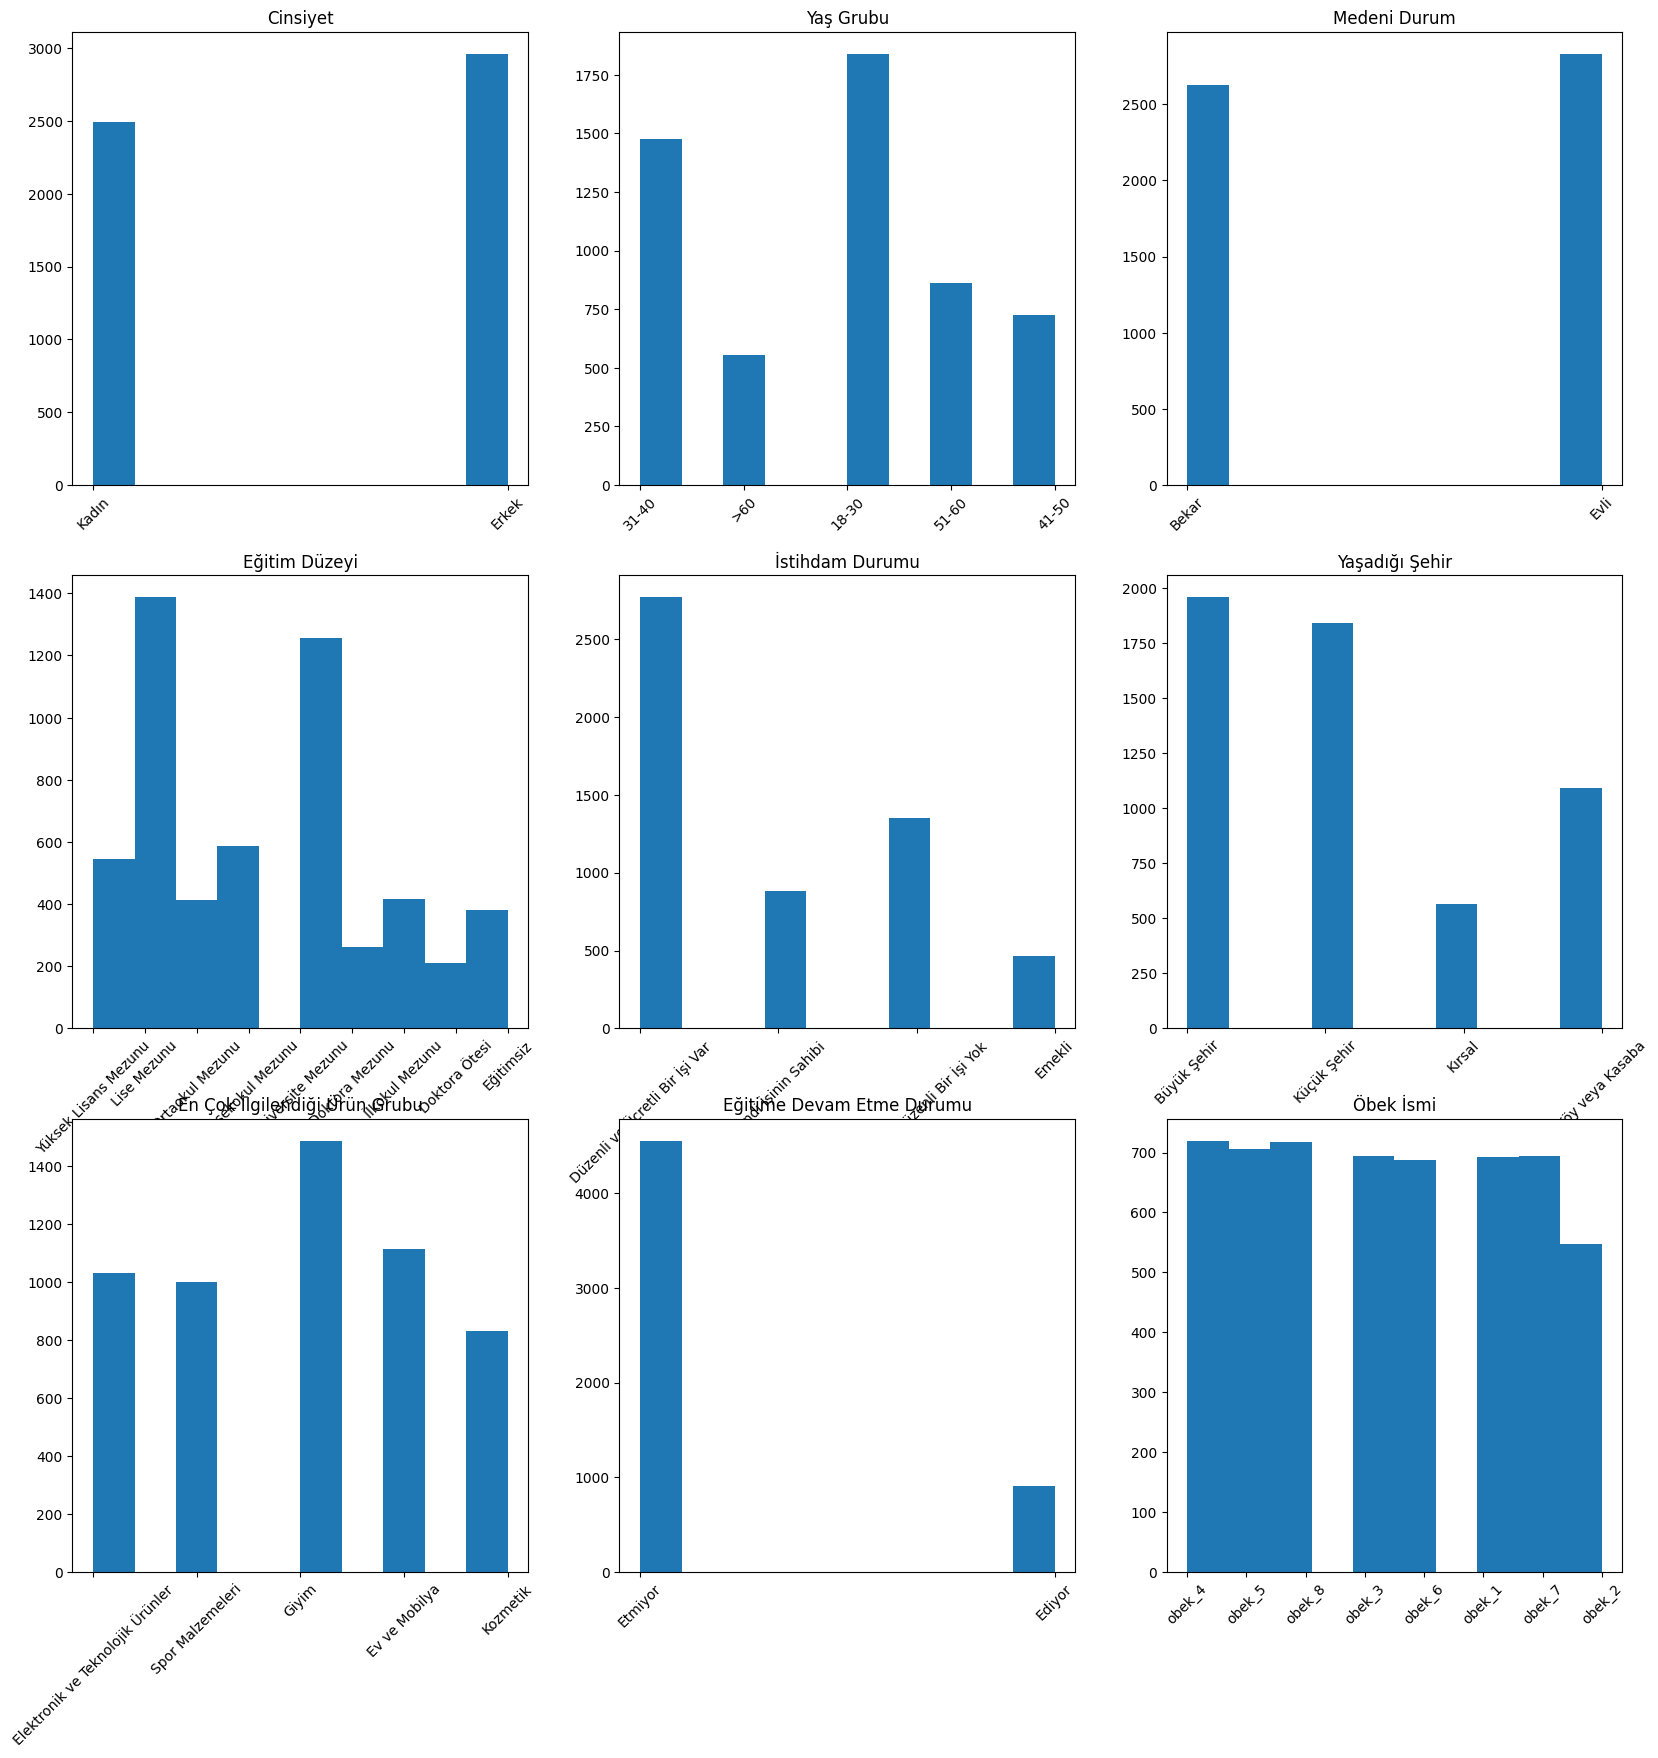

In [17]:
fig = plt.figure(figsize=(20, 20))

df_object = [col for col in raw_df.columns if raw_df[col].dtype == "object"]

# print(df_object)
for i, col in enumerate(df_object):
    plt.subplot(3, 3, i + 1)
    plt.hist(raw_df[col])
    plt.xticks(rotation=45)
    plt.title(col)

plt.show()

Yukarıda yer alan grafikle de az önce dağılımlardan elde edilen çıkarımlar desteklenmektedir.

## Sürekli Değişkenlerin İstatistiksel Konum Ölçüleri

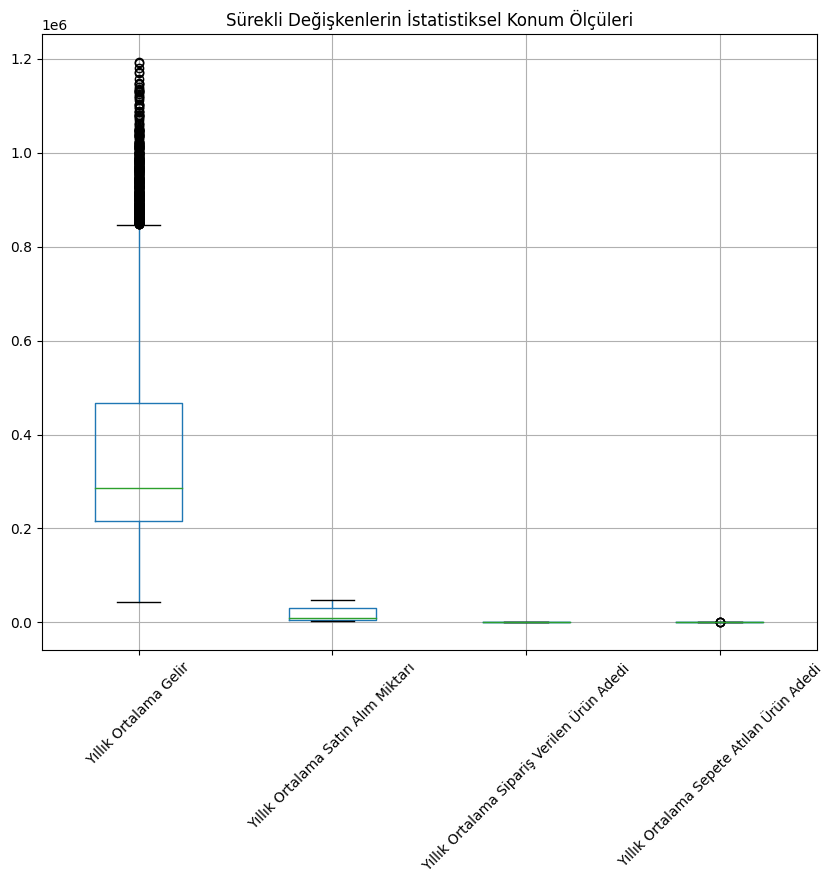

In [18]:
df_float = [col for col in raw_df.columns if raw_df[col].dtype == "float64"]

cont_list = []
for i in df_float:
    cont_list.append(raw_df[i])

cont = pd.concat(cont_list, axis=1)

plt.figure(figsize=(10, 8))
cont.boxplot()
plt.xticks(rotation=45)
plt.title("Sürekli Değişkenlerin İstatistiksel Konum Ölçüleri")
plt.show()

Sürekli değişkenlerin kutu grafikleri incelendiğinde göze çarpan iki durum vardır. Birincisi, Yıllık ortalama gelir ile 
yıllık ortalama satın alım miktarının konumları istatistiksel olarak farklı değildir. Bunun anlamı, kitlenin gelirine göre 
alışveriş yapma eğilimi değişim göstermektedir. Diğer bir konu ise Yıllık ortalama gelir ve yıllık ortalama satın alım miktarı 
değişkenlerinde birçok aykırı veri vardır.

Yıllık Ortalama gelirin kutu grafiğine bakıldığında sola çarpık bir grafik görülmektedir. Bunun anlamı yüksek gelire sahip 
deneklerin sıklığı veri seti içerisinde fazladır. Bu yorum, ortalama satın alım miktarı için de söylenebilir. Satın alm miktarı 
yüksek olan deneklerin sıklığı veri seti içerisinde fazladır. 

Veri setinin geneline bakıldığında deneklerin internet üzerindeki hareketleri, gelir ve satın alım miktarından bağımsız olabileceği 
görülmektedir. Sipariş verilen ürün adedi ile satın alım miktarı konum bakımından istatistiksel olarak anlamsızdır. Aynı 
şekilde sepete atılan ürün miktarı ve satın alım miktarı arasında da konumsal bir fark vardır. 

## Korelasyon Analizi

<Figure size 400x400 with 0 Axes>

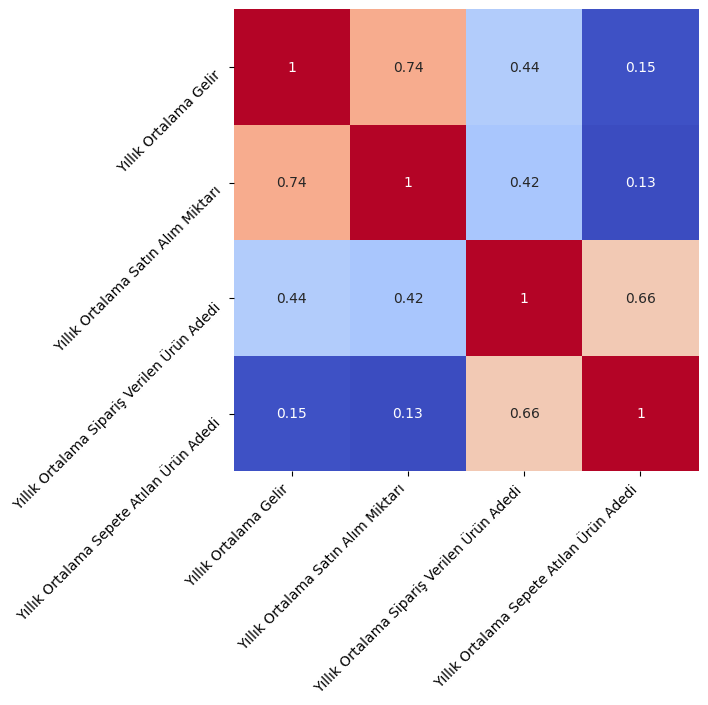

In [19]:
fig = plt.figure(figsize=(4, 4))

df_float = [col for col in raw_df.columns if raw_df[col].dtype == "float64"]

correlation = raw_df[df_float].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", cbar=False)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, va="top")

plt.show()

Korelasyon grafiğine bakıldığında ortalama satın alım miktarı ile ortalama gelir arasında %74'lük güçlü bir ilişki oluu görülmüştür. 
Yukarıda kutu grafiklerinin incelenmesinde bu ilişkinin beklenebileceği yönünde çıkarımlar yapılmıştı. Aynı zamanda yıllık ortalama 
sepete atılan ürün adedi ile ortalama sipariş verilen ürün adedi arasında %66'lık bir ilişki bulunmaktadır. Sepete atılan ürün ile satın alım miktarı ve 
gelir düzeyi arasında ise bir ilişki olmadığı saptanmıştır.

## Öbek Bazında Değişkenlerin Ortalama Bakımından Dağılımı

In [20]:
for i in df_float:
    print(raw_df.groupby("Öbek İsmi")[i].mean())

Öbek İsmi
obek_1    229513.847974
obek_2    172827.509911
obek_3    327899.094458
obek_4    817975.516312
obek_5    222224.036354
obek_6    480117.776102
obek_7    351949.976050
obek_8    255354.926670
Name: Yıllık Ortalama Gelir, dtype: float64
Öbek İsmi
obek_1     6047.195827
obek_2     4996.038895
obek_3     7360.697229
obek_4    32405.008963
obek_5     4542.305314
obek_6    39440.273682
obek_7    26429.293943
obek_8     9277.243731
Name: Yıllık Ortalama Satın Alım Miktarı, dtype: float64
Öbek İsmi
obek_1     5.865500
obek_2    20.665536
obek_3    15.209040
obek_4    38.890713
obek_5    10.697475
obek_6    29.776795
obek_7    20.279514
obek_8    49.087230
Name: Yıllık Ortalama Sipariş Verilen Ürün Adedi, dtype: float64
Öbek İsmi
obek_1     13.259577
obek_2     50.989216
obek_3     21.571290
obek_4     98.028592
obek_5     99.563686
obek_6     50.677581
obek_7     98.180834
obek_8    146.416046
Name: Yıllık Ortalama Sepete Atılan Ürün Adedi, dtype: float64


Öbek bazında değişkenler yorumlanırsa en çok göze çarpan içgörünün en yüksek gelire sahip olan öbeğin 4 numaralı öbek olduğu 
görülmektedir. Her ne kadar satın alım ve gelir arasında güçlü bir korelasyon görsek de en yüksek alım istatistiği 4 numaralı 
öbeğe ait değil, 6 numaralı öbeğe aittir. Ayrıca 6 numaralı öbeğin gelir bakımından 4 numaralı öbeğin neredeyse yarısı olması 
oldukça dikkat çekicidir. Öbek 6 ve 4'ün aynı zamanda sıklık olarak en az alışveriş yapan grup olduğu görülmüştür. Sepete atma ve 
tane bazlı satım alım miktarı istatistikleri düşük olan bu gruplar hakkında alışverişlerde pahalı ürünleri tercih ediyor yorumu yapılabilir. 
Ayrıca, örnek olarak öbek 1'in en az gelir düzeyine sahip öbek olduğu söylenebilir. Buna karşılık alışeriş sıklıkları ve harcamaları da daha az. 
Böylece bu grup için tutumlu yorumu yapılabilmektedir. 

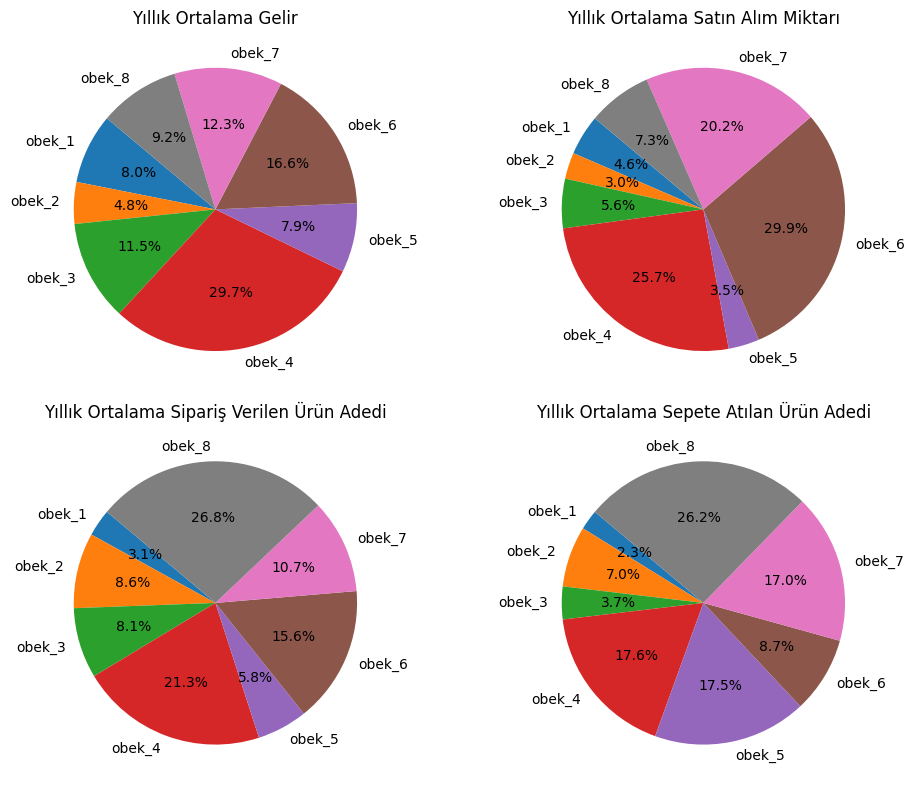

In [21]:
grouped_income = raw_df.groupby("Öbek İsmi")["Yıllık Ortalama Gelir"].sum()
grouped_purchase = raw_df.groupby("Öbek İsmi")[
    "Yıllık Ortalama Satın Alım Miktarı"
].sum()
grouped_order = raw_df.groupby("Öbek İsmi")[
    "Yıllık Ortalama Sipariş Verilen Ürün Adedi"
].sum()
grouped_basket = raw_df.groupby("Öbek İsmi")[
    "Yıllık Ortalama Sepete Atılan Ürün Adedi"
].sum()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Pie chart for Yıllık Ortalama Gelir
axes[0, 0].pie(
    grouped_income, labels=grouped_income.index, autopct="%.1f%%", startangle=140
)
axes[0, 0].set_title("Yıllık Ortalama Gelir")

# Pie chart for Yıllık Ortalama Satın Alım Miktarı
axes[0, 1].pie(
    grouped_purchase, labels=grouped_purchase.index, autopct="%.1f%%", startangle=140
)
axes[0, 1].set_title("Yıllık Ortalama Satın Alım Miktarı")

# Pie chart for Yıllık Ortalama Sipariş Verilen Ürün Adedi
axes[1, 0].pie(
    grouped_order, labels=grouped_order.index, autopct="%.1f%%", startangle=140
)
axes[1, 0].set_title("Yıllık Ortalama Sipariş Verilen Ürün Adedi")

# Pie chart for Yıllık Ortalama Sepete Atılan Ürün Adedi
axes[1, 1].pie(
    grouped_basket, labels=grouped_basket.index, autopct="%.1f%%", startangle=140
)
axes[1, 1].set_title("Yıllık Ortalama Sepete Atılan Ürün Adedi")

plt.tight_layout()
plt.show()

Yukarıda pasta grafiklerde görüldüğü üzere ene yüksek orta gelirliler öbek 4'te bulunmaktadır. Buna oranla satın alım miktarları kitle içerisinde gelirlerine oranla dengelidir. 4 numaralı öbeğin yüksek gelirine kıyasla dengeli bir satın alım hareketi gerçekleştirmesi bu öbek hakkında tutumlu yorumu yapılmasına olanak sağlamaktadır. Öbekler arasında satım alım davranışı olarak en çok göze çarpan Öbek 6'dır. En yüksek 2. gelir grubu olmalarına karşın öbek 4'ün yarısı kadar gelir düzeyine sahipler ve diğer öbeklerin gelirlerine daha fazla yakınlık göstermektedirler. Öbek 6, gelir düzeylerine karşılık en yüksek harcama yapan grup olarak göze çarpmaktadır. Gelir düzeylerine nazaran yüksek satın alım hareketleri bu grubu savurgan olarak adlandırmaya yol açmaktadır. Grafik üzerinde bu yorumlar yapılabilirken gelir düzeyine göre satın alım miktarları oranlanarak daha efektif yorumlar elde edilebilir.

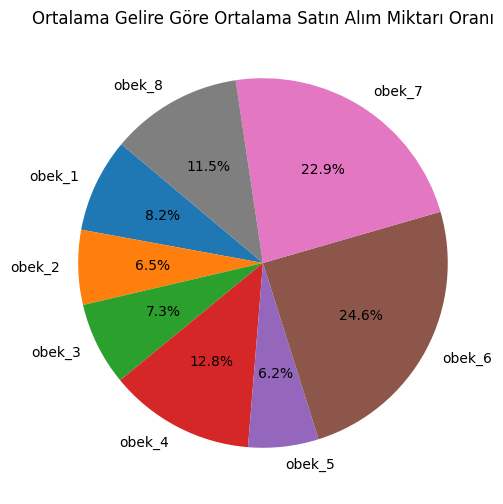

In [22]:
raw_df_feature = raw_df.copy()
raw_df_feature["Ortalama_Gelire_Göre_Ortalama_Alım"] = (
    raw_df["Yıllık Ortalama Satın Alım Miktarı"] / raw_df["Yıllık Ortalama Gelir"]
)
grouped_purchase_ratio = raw_df_feature.groupby("Öbek İsmi")[
    "Ortalama_Gelire_Göre_Ortalama_Alım"
].sum()

plt.figure(figsize=(6, 6))  # Adjust the figure size as needed

plt.pie(
    grouped_purchase_ratio,
    labels=grouped_purchase_ratio.index,
    autopct="%.1f%%",
    startangle=140,
)
plt.title("Ortalama Gelire Göre Ortalama Satın Alım Miktarı Oranı")
plt.show()

Yukarıdaki grafikte deneklerin öbek bazında yıllık ortalama gelirlerine göre yıllık ortalama satın alım miktarları gözlenmektedir. Bu oran, öbeklerin finansal davranışları hakkında bilgi vermektedir. Az önceki grafikte öbek 6 için savurgan yorumu yapılmıştı. Bu grafiğe göre öbek 7 için de benzer bir yorum yapılabilir. Öbeklerin karakteristiği çıkarılırken daha fazla değişkenden yararlanılmalıdır. 

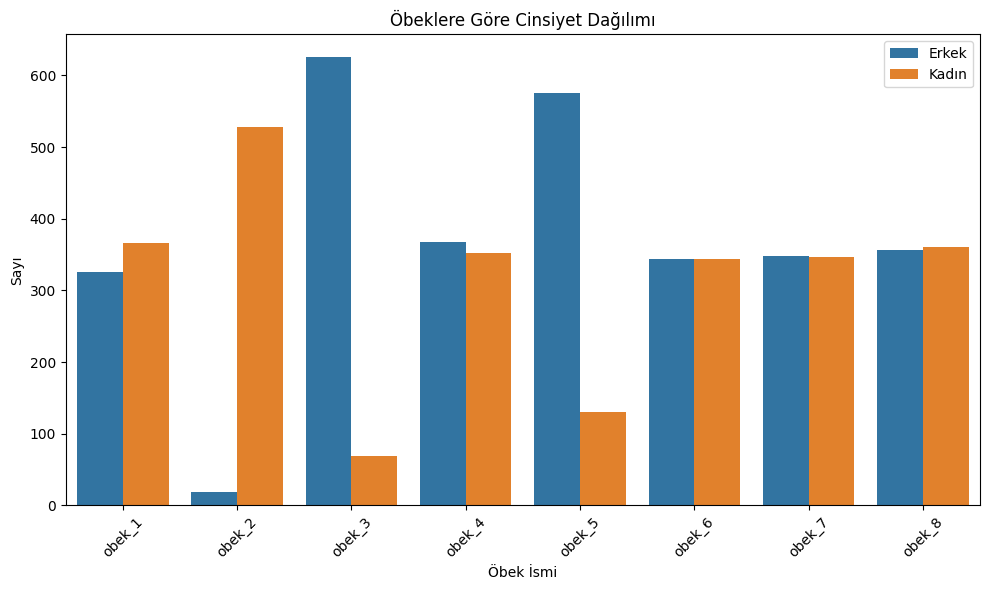

In [23]:
gender_distribution = (
    raw_df.groupby(["Öbek İsmi", "Cinsiyet"]).size().reset_index(name="Count")
)
plt.figure(figsize=(10, 6))
sns.barplot(x="Öbek İsmi", y="Count", hue="Cinsiyet", data=gender_distribution)
plt.xlabel("Öbek İsmi")
plt.ylabel("Sayı")
plt.title("Öbeklere Göre Cinsiyet Dağılımı")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

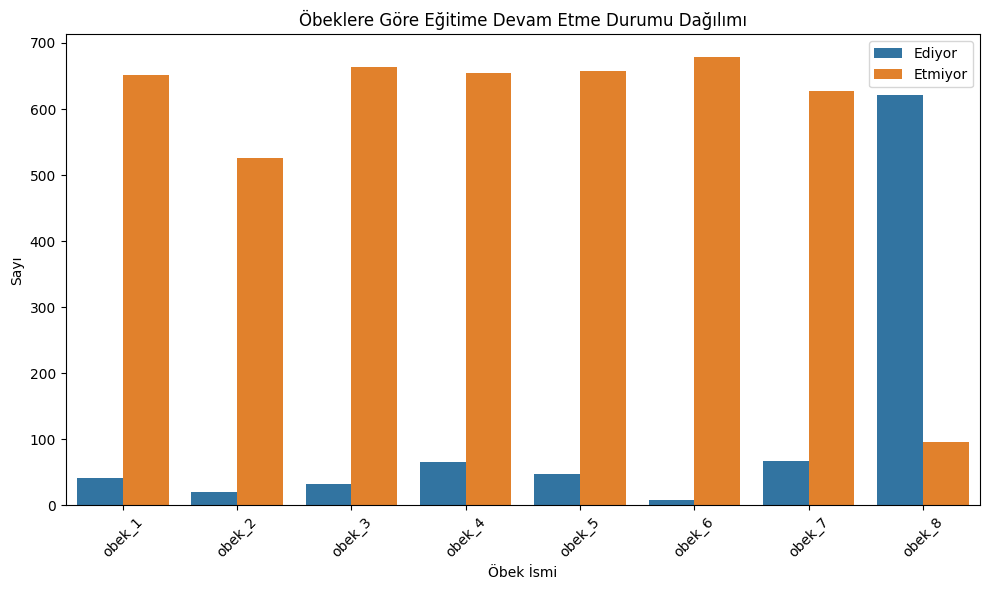

In [24]:
edustatus_distribution = (
    raw_df.groupby(["Öbek İsmi", "Eğitime Devam Etme Durumu"])
    .size()
    .reset_index(name="Count")
)
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Öbek İsmi",
    y="Count",
    hue="Eğitime Devam Etme Durumu",
    data=edustatus_distribution,
)
plt.xlabel("Öbek İsmi")
plt.ylabel("Sayı")
plt.title("Öbeklere Göre Eğitime Devam Etme Durumu Dağılımı")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

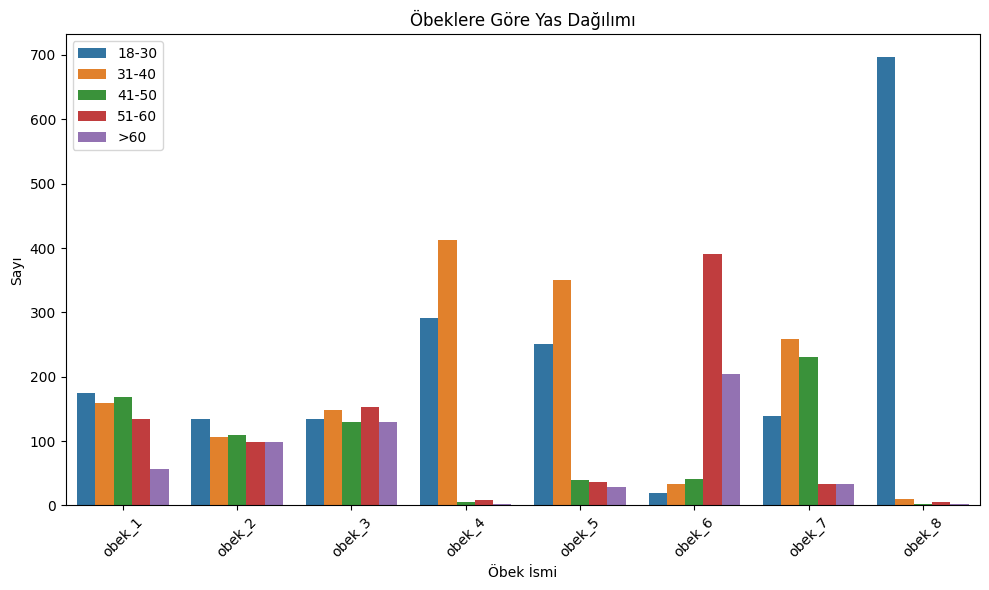

In [25]:
age_distribution = (
    raw_df.groupby(["Öbek İsmi", "Yaş Grubu"]).size().reset_index(name="Count")
)
plt.figure(figsize=(10, 6))
sns.barplot(x="Öbek İsmi", y="Count", hue="Yaş Grubu", data=age_distribution)
plt.xlabel("Öbek İsmi")
plt.ylabel("Sayı")
plt.title("Öbeklere Göre Yas Dağılımı")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

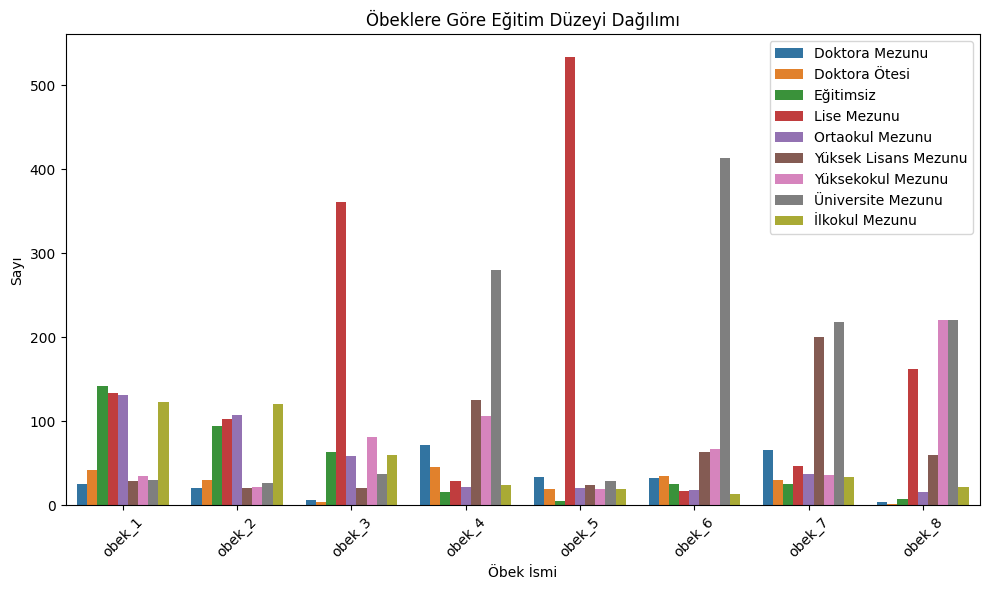

In [26]:
education_distribution = (
    raw_df.groupby(["Öbek İsmi", "Eğitim Düzeyi"]).size().reset_index(name="Count")
)
plt.figure(figsize=(10, 6))
sns.barplot(x="Öbek İsmi", y="Count", hue="Eğitim Düzeyi", data=education_distribution)
plt.xlabel("Öbek İsmi")
plt.ylabel("Sayı")
plt.title("Öbeklere Göre Eğitim Düzeyi Dağılımı")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

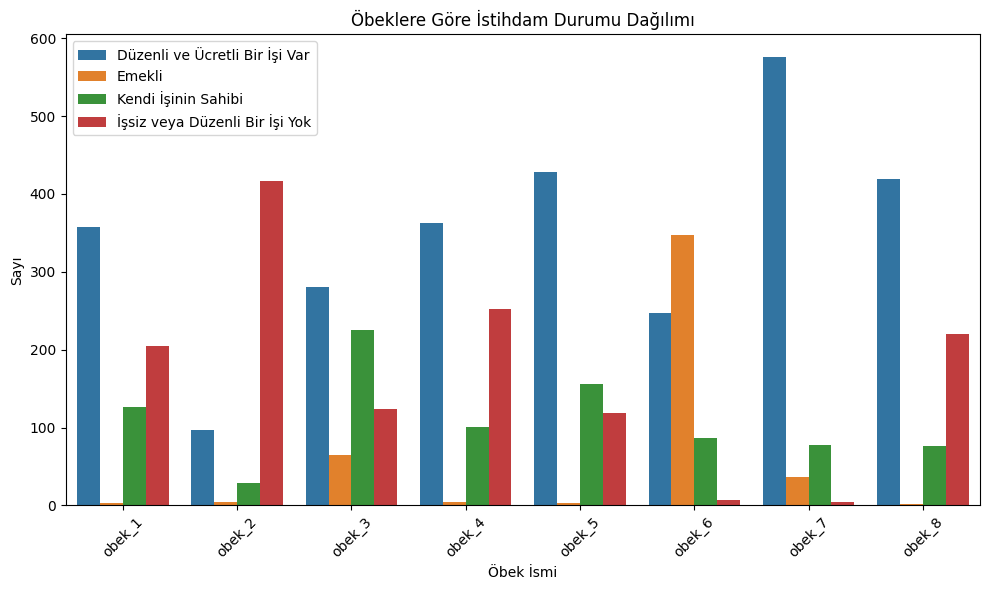

In [27]:
employment_distribution = (
    raw_df.groupby(["Öbek İsmi", "İstihdam Durumu"]).size().reset_index(name="Count")
)
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Öbek İsmi", y="Count", hue="İstihdam Durumu", data=employment_distribution
)
plt.xlabel("Öbek İsmi")
plt.ylabel("Sayı")
plt.title("Öbeklere Göre İstihdam Durumu Dağılımı")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Yukarıda grafiklere bakıldığında öbek 1 için çalışan ancak düşük gelirli olan deneklerin bir araya geldiği bir grup olarak gözüküyor. Öbek 2 için ise yine dar gelirli yorumu yapılabilir ancak bu kitlede çalışma oranı oldukça azdır. Ayrıca her iki öbek de sayın alım daranışlarına göre tutumludur. Her iki grup için de eğitim düzeyi olarak dengeli bir dağılım gözlenmektedir. Öbek 4'ün istiham oranı öbek 1 ile benzerlik göstermektedir. Ancak eğitim düzeyi olarak farkları araştırıldığında öbek 4'te üniversite mezunlarının yoğunluklu olduğunu görmekteyiz. Öbek 5, genel olarak maaşlı çalışan ve lise mezunu olan deneklerin yoğunluklu olduğu bir grup olarak gözleniyor. Dar bir gelir düzeyine sahipler ve sıkı bir tutumluluk hareketi var. Bu grup için tasarruflu yorumu yapılabilmektedir. Yoğunluklu olarak emeklilerin oluşturduğu öbek 6, gelir - harcama eğilimine bakılığında dengeli bir durumda gözlenmektedir. Neredeyse çalışmayan ve geliri olmayan kimsenin olmadığı öbek 7, en yüksek 2. gelir düzeyine sahip. Buna karşılık daha önce de bahsedildiği gibi yüksek bir satın alım hareketi gözlenmektedir. Öbek 8 ise yoğunluklu olarak çalışan ve gelir - satın alım dengesine göre dengeli bir tutum izleyen öbek olarak öne çıkmaktadır. 

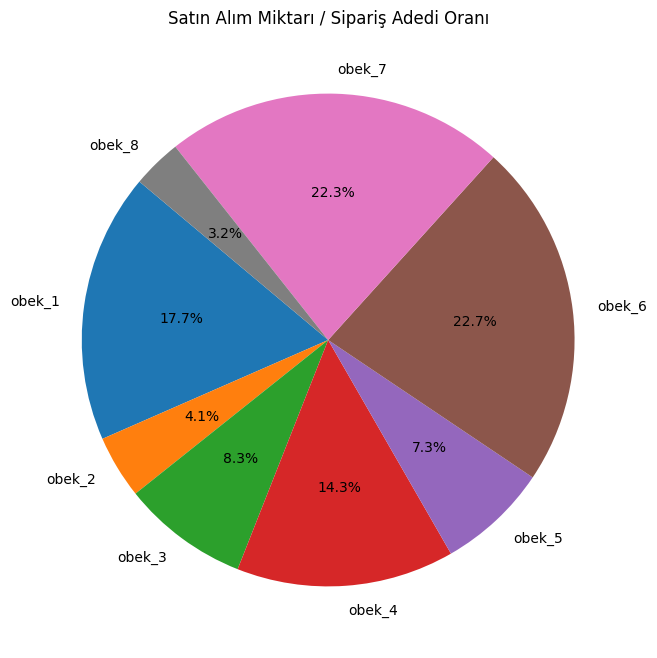

In [28]:
purchase_order_ratio = grouped_purchase / grouped_order

plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

plt.pie(
    purchase_order_ratio,
    labels=purchase_order_ratio.index,
    autopct="%.1f%%",
    startangle=140,
)
plt.title("Satın Alım Miktarı / Sipariş Adedi Oranı")
plt.show()

Yukarıdaki grafikte grupların satın alım tercihleri hakkında bilgi sağlayan bir grafik verilmiştir. Yukarıda dengeli bir gelir - satın alım hareketi yürüten emekli yoğunluklu öbek 6, pahalı ürünlere en çok ilgi gösteren grup olmuştur. Bununla birlikte pahalı ürünlere ilgi gösteren bir diğer grup ise savurgan bir tutum izleyen öbek 4 olmuştur.

## Shannon Entropisi

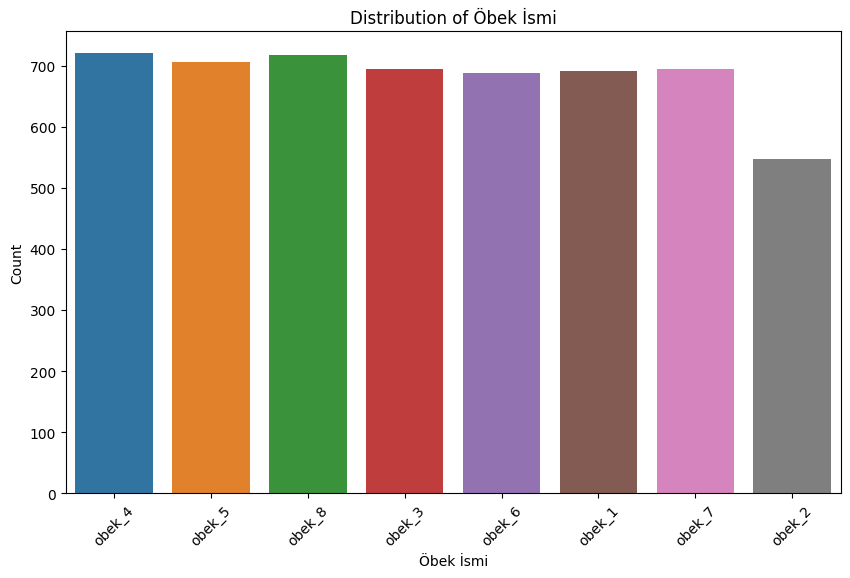

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(data=raw_df, x="Öbek İsmi")
plt.title("Distribution of Öbek İsmi")
plt.xlabel("Öbek İsmi")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [30]:
def shannon_entropy(seq):
    n = len(seq)
    classes = [(clas, float(count)) for clas, count in Counter(seq).items()]
    k = len(classes)

    H = -sum(
        [(count / n) * log((count / n)) for clas, count in classes]
    )  # shannon entropy
    return H / log(k)


entropy = shannon_entropy(raw_df["Öbek İsmi"])
print(entropy)

0.9985003746688047


In [31]:
insight = {
    "Öbek": [1, 2, 3, 4, 5, 6, 7, 8],
    "Gelir Düzeyi": [
        "Düşük",
        "Düşük",
        "Orta",
        "Yüksek",
        "Düşük",
        "Orta",
        "Yüksek",
        "Düşük",
    ],
    "Harcama": [
        "Tasarruflu",
        "Dengeli",
        "Dengeli",
        "Dengeli",
        "Tasarruflu",
        "Savurgan",
        "Savurgan",
        "Dengeli",
    ],
    "İstihdam": [
        "Çalışıyor",
        "İşsiz",
        "Çalışıyor",
        "Çalışıyor",
        "Çalışıyor",
        "Emekli",
        "Çalışıyor",
        "Öğrenci",
    ],
    "Yaş": ["Dengeli", "Dengeli", "Dengeli", "Genç", "Genç", "Yaşlı", "Orta", "Genç"],
    "Ürün Fiyat": ["Orta", "Ucuz", "Orta", "Orta", "Orta", "Pahalı", "Pahalı", "Ucuz"],
}

df_insight = pd.DataFrame(insight)
df_insight

,Öbek,Gelir Düzeyi,Harcama,İstihdam,Yaş,Ürün Fiyat
0,1,Düşük,Tasarruflu,Çalışıyor,Dengeli,Orta
1,2,Düşük,Dengeli,İşsiz,Dengeli,Ucuz
2,3,Orta,Dengeli,Çalışıyor,Dengeli,Orta
3,4,Yüksek,Dengeli,Çalışıyor,Genç,Orta
4,5,Düşük,Tasarruflu,Çalışıyor,Genç,Orta
5,6,Orta,Savurgan,Emekli,Yaşlı,Pahalı
6,7,Yüksek,Savurgan,Çalışıyor,Orta,Pahalı
7,8,Düşük,Dengeli,Öğrenci,Genç,Ucuz


### X ve y Değişkenin Ayrılması

In [32]:
raw_X = raw_df.drop("Öbek İsmi", axis=1)
raw_y = raw_df["Öbek İsmi"]

# Model Seçimi

Ilk olarak multiclass klasifikasyon yaparken kullanacabilecegimiz modellerin verilen dataset uzerindeki skolarini olcerek performanslarini kiyaslamak istedik. Model performanslarını takip etmek için çapraz doğrulama kullanıldı.

## Model Performansları

In [33]:
base_X = encode_X(raw_X, ordinal_encoding=["Yaş Grubu", "Eğitim Düzeyi"])
base_y = encode_y(raw_y)

In [34]:
base_model_performance_df = pd.DataFrame(
    columns=[
        "Model İsmi",
        "Minimum Çapraz Doğrulama Skoru",
        "Maksimum Çapraz Doğrulama Skoru",
        "Ortalama Çapraz Doğrulama Skoru",
        "Çapraz Doğrulama Standart Sapma",
    ]
)

### Logistic Regressiyon

In [35]:
lg = LogisticRegression(max_iter=1000)
lg_cv_scores = cross_val_score(lg, base_X, base_y, cv=5, scoring="accuracy")
print(f"Logistic Regression CV Scores: {lg_cv_scores}")
print(f"Logistic Regression CV Mean Score: {lg_cv_scores.mean()}")
print(f"Logistic Regression CV Standard Deviation: {lg_cv_scores.std()}")

Logistic Regression CV Scores: [0.92948718 0.94413919 0.95054945 0.94139194 0.93956044]
Logistic Regression CV Mean Score: 0.941025641025641
Logistic Regression CV Standard Deviation: 0.00686752134038557


In [36]:
new_row = {
    "Model İsmi": "Logistic Regression",
    "Minimum Çapraz Doğrulama Skoru": lg_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": lg_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": lg_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": lg_cv_scores.std(),
}
base_model_performance_df.loc[len(base_model_performance_df)] = new_row

### Karar Ağacı

In [37]:
clf = DecisionTreeClassifier(random_state=42)
clf_cv_scores = cross_val_score(clf, base_X, base_y, cv=5, scoring="accuracy")
print(f"Decision Tree CV Scores: {clf_cv_scores}")
print(f"Decision Tree CV Mean Score: {clf_cv_scores.mean()}")
print(f"Decision Tree CV Standard Deviation: {clf_cv_scores.std()}")

Decision Tree CV Scores: [0.89285714 0.89285714 0.92032967 0.89377289 0.8974359 ]
Decision Tree CV Mean Score: 0.8994505494505495
Decision Tree CV Standard Deviation: 0.010575238119598535


In [38]:
new_row = {
    "Model İsmi": "Karar Ağacı",
    "Minimum Çapraz Doğrulama Skoru": clf_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": clf_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": clf_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": clf_cv_scores.std(),
}
base_model_performance_df.loc[len(base_model_performance_df)] = new_row

### Rastgele Ormanlar

In [39]:
rf = RandomForestClassifier(random_state=42)
rf_cv_scores = cross_val_score(rf, base_X, base_y, cv=5, scoring="accuracy")
print(f"Random Forest CV Scores: {rf_cv_scores}")
print(f"Random Forest CV Mean Score: {rf_cv_scores.mean()}")
print(f"Random Forest CV Standard Deviation: {rf_cv_scores.std()}")

Random Forest CV Scores: [0.94413919 0.95604396 0.96428571 0.95512821 0.95421245]
Random Forest CV Mean Score: 0.9547619047619047
Random Forest CV Standard Deviation: 0.00641287230769657


In [40]:
new_row = {
    "Model İsmi": "Rastgele Ormanlar",
    "Minimum Çapraz Doğrulama Skoru": rf_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": rf_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": rf_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": rf_cv_scores.std(),
}
base_model_performance_df.loc[len(base_model_performance_df)] = new_row

### CatBoost

CatBoost algoritmasının çok sınıflı sınıflandırma yapabilmesi için gereken minimum parametreler tanımlandı.

In [41]:
catb = cb.CatBoostClassifier(
    classes_count=8, loss_function="MultiClass", random_state=42, verbose=False
)
catb_cv_scores = cross_val_score(catb, base_X, base_y, cv=5, scoring="accuracy")
print(f"CatBoost CV Scores: {catb_cv_scores}")
print(f"CatBoost CV Mean Score: {catb_cv_scores.mean()}")
print(f"CatBoost CV Standard Deviation: {catb_cv_scores.std()}")

CatBoost CV Scores: [0.94413919 0.95604396 0.96336996 0.95512821 0.95421245]
CatBoost CV Mean Score: 0.9545787545787545
CatBoost CV Standard Deviation: 0.006145773529510096


In [42]:
new_row = {
    "Model İsmi": "CatBoost",
    "Minimum Çapraz Doğrulama Skoru": catb_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": catb_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": catb_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": catb_cv_scores.std(),
}
base_model_performance_df.loc[len(base_model_performance_df)] = new_row

### XGBoost

XGBoost algoritmasının çok sınıflı sınıflandırma yapabilmesi için gereken minimum parametreler tanımlandı.

In [43]:
xgbos = xgb.XGBClassifier(
    objective="multi:softmax",
    eval_metric="merror",
    num_class=8,
    random_state=42,
    verbosity=0,
)
xgbos_cv_scores = cross_val_score(xgbos, base_X, base_y, cv=5, scoring="accuracy")
print(f"XGBoost CV Scores: {xgbos_cv_scores}")
print(f"XGBoost CV Mean Score: {xgbos_cv_scores.mean()}")
print(f"XGBoost CV Standard Deviation: {xgbos_cv_scores.std()}")

XGBoost CV Scores: [0.94139194 0.95604396 0.95970696 0.95421245 0.95238095]
XGBoost CV Mean Score: 0.9527472527472527
XGBoost CV Standard Deviation: 0.006173003496832518


In [44]:
new_row = {
    "Model İsmi": "XGBoost",
    "Minimum Çapraz Doğrulama Skoru": xgbos_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": xgbos_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": xgbos_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": xgbos_cv_scores.std(),
}
base_model_performance_df.loc[len(base_model_performance_df)] = new_row

## Sonuçlar

In [45]:
base_model_performance_df

,Model İsmi,Minimum Çapraz Doğrulama Skoru,Maksimum Çapraz Doğrulama Skoru,Ortalama Çapraz Doğrulama Skoru,Çapraz Doğrulama Standart Sapma
0,Logistic Regression,0.929487,0.950549,0.941026,0.006868
1,Karar Ağacı,0.892857,0.920330,0.899451,0.010575
2,Rastgele Ormanlar,0.944139,0.964286,0.954762,0.006413
3,CatBoost,0.944139,0.963370,0.954579,0.006146
4,XGBoost,0.941392,0.959707,0.952747,0.006173


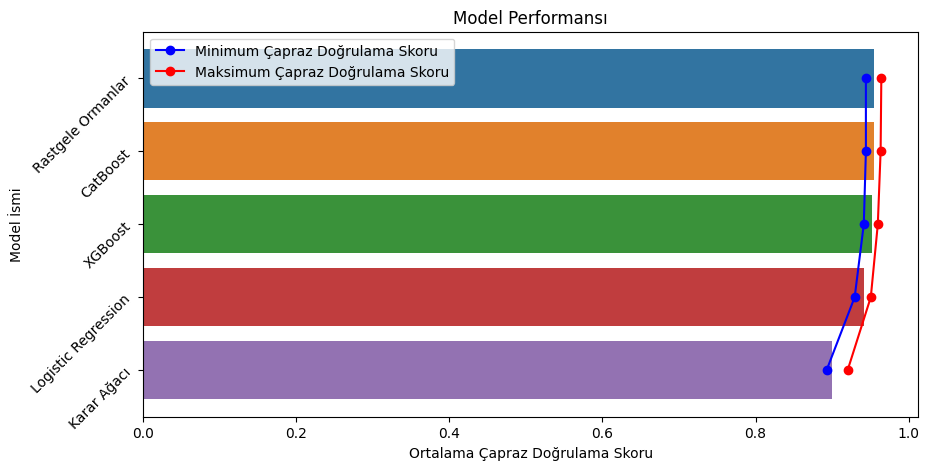

In [46]:
plot_model_performance(base_model_performance_df, "Model İsmi")

En iyi çalışan model rastgele ormanlar olduğundan veriseti üzerindeki değişiklikleri rastgele ormanlar üzerinden takip etmeye karar verildi.

# Özellik Mühendisliği

## Aykırı Değer Tespiti

In [47]:
rf_performance_outliers = pd.DataFrame(
    columns=[
        "Method İsmi",
        "Etkilenen Girdi Sayısı",
        "Minimum Çapraz Doğrulama Skoru",
        "Maksimum Çapraz Doğrulama Skoru",
        "Ortalama Çapraz Doğrulama Skoru",
        "Çapraz Doğrulama Standart Sapma",
    ]
)

rf = RandomForestClassifier(random_state=42)
rf_cv_scores = cross_val_score(rf, base_X, base_y, cv=5, scoring="accuracy")
new_row = {
    "Method İsmi": "Ham Veri",
    "Etkilenen Girdi Sayısı": 0,
    "Minimum Çapraz Doğrulama Skoru": rf_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": rf_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": rf_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": rf_cv_scores.std(),
}
rf_performance_outliers.loc[len(rf_performance_outliers)] = new_row

continuos_cols = [
    "Yıllık Ortalama Gelir",
    "Yıllık Ortalama Satın Alım Miktarı",
    "Yıllık Ortalama Sipariş Verilen Ürün Adedi",
    "Yıllık Ortalama Sepete Atılan Ürün Adedi",
]

### IQR Methodu

In [48]:
Q1 = raw_X[continuos_cols].quantile(0.25)
Q3 = raw_X[continuos_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = (raw_X[continuos_cols] < (Q1 - 1.5 * IQR)) | (
    raw_X[continuos_cols] > (Q3 + 1.5 * IQR)
)
print("IQR Aykırı Değerleri:")
print(outliers.sum())

IQR Aykırı Değerleri:
Yıllık Ortalama Gelir                         380
Yıllık Ortalama Satın Alım Miktarı              0
Yıllık Ortalama Sipariş Verilen Ürün Adedi      0
Yıllık Ortalama Sepete Atılan Ürün Adedi        4
dtype: int64


In [49]:
iqr_X = encode_X(
    raw_X[~outliers.any(axis=1)], ordinal_encoding=["Yaş Grubu", "Eğitim Düzeyi"]
)
iqr_y = encode_y(raw_y[~outliers.any(axis=1)])

In [50]:
iqr_cv_scores = cross_val_score(rf, iqr_X, iqr_y, cv=5, scoring="accuracy")
print(f"IQR CV Scores: {iqr_cv_scores}")
print(f"IQR CV Mean Score: {iqr_cv_scores.mean()}")
print(f"IQR CV Standard Deviation: {iqr_cv_scores.std()}")

IQR CV Scores: [0.93996063 0.96157635 0.96157635 0.95073892 0.95862069]
IQR CV Mean Score: 0.9544945890384392
IQR CV Standard Deviation: 0.008278509058583182


In [51]:
new_row = {
    "Method İsmi": "IQR",
    "Etkilenen Girdi Sayısı": outliers.sum().sum(),
    "Minimum Çapraz Doğrulama Skoru": iqr_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": iqr_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": iqr_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": iqr_cv_scores.std(),
}
rf_performance_outliers.loc[len(rf_performance_outliers)] = new_row

### Z-Skor

In [52]:
# Compute z-scores for numerical columns
z_scores = np.abs(stats.zscore(raw_X[continuos_cols]))
# Find indices of outliers based on z-scores
outliers = np.where(z_scores > 3)[0]  # You can adjust the threshold
print("Z-Skor Aykırı Değerleri:")
len(outliers)

Z-Skor Aykırı Değerleri:


72

In [53]:
# Drop the outliers
z_X = encode_X(
    raw_X.drop(outliers, axis=0), ordinal_encoding=["Yaş Grubu", "Eğitim Düzeyi"]
)
z_y = encode_y(raw_y.drop(outliers, axis=0))

In [54]:
z_cv_scores = cross_val_score(rf, z_X, z_y, cv=5, scoring="accuracy")
print(f"Z-Skor CV Scores: {z_cv_scores}")
print(f"Z-Skor CV Mean Score: {z_cv_scores.mean()}")
print(f"Z-Skor CV Standard Deviation: {z_cv_scores.std()}")

Z-Skor CV Scores: [0.94341373 0.9554731  0.96382189 0.95450325 0.95636026]
Z-Skor CV Mean Score: 0.9547144459201762
Z-Skor CV Standard Deviation: 0.006541874998746164


In [55]:
new_row = {
    "Method İsmi": "Z-Skor",
    "Etkilenen Girdi Sayısı": len(outliers),
    "Minimum Çapraz Doğrulama Skoru": z_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": z_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": z_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": z_cv_scores.std(),
}
rf_performance_outliers.loc[len(rf_performance_outliers)] = new_row

### Winsorize

In [56]:
# Create a dictionary to store the number of values changed for each column
values_changed_dict = {}
winsorized_X = raw_X.copy()
# Loop through columns and apply winsorize
for col in continuos_cols:
    original_values = raw_X[col].copy()  # Make a copy of the original column
    winsorized_values = winsorize(raw_X[col], limits=[0.05, 0.05])
    winsorized_X[col] = winsorize(winsorized_X[col], (0.05, 0.05))
    values_changed = (original_values != winsorized_values).sum()
    values_changed_dict[col] = values_changed

# Print the number of values changed for each column
for col, values_changed in values_changed_dict.items():
    print(f"{col}: {values_changed} değer değiştirildi.")

Yıllık Ortalama Gelir: 546 değer değiştirildi.
Yıllık Ortalama Satın Alım Miktarı: 546 değer değiştirildi.
Yıllık Ortalama Sipariş Verilen Ürün Adedi: 546 değer değiştirildi.
Yıllık Ortalama Sepete Atılan Ürün Adedi: 546 değer değiştirildi.


In [57]:
winsorize_X = encode_X(winsorized_X, ordinal_encoding=["Yaş Grubu", "Eğitim Düzeyi"])
winsorize_y = encode_y(raw_y)

In [58]:
winsorize_cv_scores = cross_val_score(
    rf, winsorize_X, winsorize_y, cv=5, scoring="accuracy"
)
print(f"Winsorize CV Scores: {winsorize_cv_scores}")
print(f"Winsorize CV Mean Score: {winsorize_cv_scores.mean()}")
print(f"Winsorize CV Standard Deviation: {winsorize_cv_scores.std()}")

Winsorize CV Scores: [0.94322344 0.95604396 0.96428571 0.95512821 0.95421245]
Winsorize CV Mean Score: 0.9545787545787545
Winsorize CV Standard Deviation: 0.006719390596279919


In [59]:
new_row = {
    "Method İsmi": "Winsorize",
    "Etkilenen Girdi Sayısı": sum(values_changed_dict.values()),
    "Minimum Çapraz Doğrulama Skoru": winsorize_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": winsorize_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": winsorize_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": winsorize_cv_scores.std(),
}
rf_performance_outliers.loc[len(rf_performance_outliers)] = new_row

### Sonuçlar

In [60]:
rf_performance_outliers

,Method İsmi,Etkilenen Girdi Sayısı,Minimum Çapraz Doğrulama Skoru,Maksimum Çapraz Doğrulama Skoru,Ortalama Çapraz Doğrulama Skoru,Çapraz Doğrulama Standart Sapma
0,Ham Veri,0,0.944139,0.964286,0.954762,0.006413
1,IQR,384,0.939961,0.961576,0.954495,0.008279
2,Z-Skor,72,0.943414,0.963822,0.954714,0.006542
3,Winsorize,2184,0.943223,0.964286,0.954579,0.006719


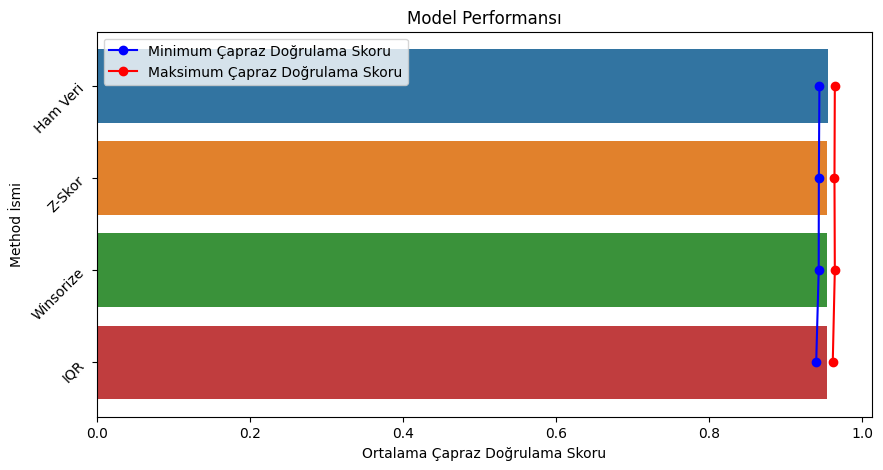

In [61]:
plot_model_performance(rf_performance_outliers, "Method İsmi")

Veri miktarını düşürmek istenmediğinden winsorization ile çalışmaya devam edildi.

## Özellik Oluşturma

In [62]:
continuos_cols = [
    "Yıllık Ortalama Gelir",
    "Yıllık Ortalama Satın Alım Miktarı",
    "Yıllık Ortalama Sipariş Verilen Ürün Adedi",
    "Yıllık Ortalama Sepete Atılan Ürün Adedi",
]

featured_X = raw_X.copy()
# Loop through columns and apply winsorize
for col in continuos_cols:
    featured_X[col] = winsorize(raw_X[col], limits=[0.05, 0.05])

In [63]:
# Yıllık Ortalama Sipariş Verilen Ürün Adedi ile Yıllık Ortalama Gelir arasındaki ortalama sipariş miktarı hesaplanıyor
featured_X["Ortalama_Sipariş_Başına_Gelir"] = (
    raw_X["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] / raw_X["Yıllık Ortalama Gelir"]
)

# Yıllık Ortalama Satın Alım Miktarı ile Yıllık Ortalama Gelir arasındaki ortalama satın alma miktarı hesaplanıyor
featured_X["Ortalama_Satın_Alma_Başına_Gelir"] = (
    raw_X["Yıllık Ortalama Satın Alım Miktarı"] / raw_X["Yıllık Ortalama Gelir"]
)

# Yıllık Ortalama Sipariş Verilen Ürün Adedi ile Yıllık Ortalama Sepete Atılan Ürün Adedi arasındaki ortalama ürün adeti hesaplanıyor
featured_X["Ortalama_Sipariş_Başına_Sepetteki_Ürün"] = (
    raw_X["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]
    / raw_X["Yıllık Ortalama Sepete Atılan Ürün Adedi"]
)

# Yıllık Ortalama Satın Alım Miktarı ile Yıllık Ortalama Sipariş Verilen Ürün Adedi arasındaki ortalama ürün fiyatı hesaplanıyor
featured_X["Ortalama_Ürün_Başına_Fiyat"] = (
    raw_X["Yıllık Ortalama Satın Alım Miktarı"]
    / raw_X["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]
)

# Sonsuz veya negatif değerler 0 ile değiştiriliyor
featured_X.replace([np.inf, -np.inf], 0, inplace=True)

In [64]:
# "Yıllık Ortalama Gelir" verisi için çeyreklikler ve IQR değeri hesaplanıyor
q1 = np.percentile(featured_X["Yıllık Ortalama Gelir"], 25)
median = np.median(featured_X["Yıllık Ortalama Gelir"])
q3 = np.percentile(featured_X["Yıllık Ortalama Gelir"], 75)
iqr = q3 - q1

# Alt ve üst sınırlar hesaplanıyor
minimum = q1 - 1.5 * iqr
maximum = q3 + 1.5 * iqr

# Gelir seviyeleri için aralık sınırları belirleniyor ve etiketler atanıyor
bin_edges = [0, minimum, q1, median, q3, maximum, float("inf")]
bin_edges.sort()
bin_labels = [
    "çok düşük",
    "düşük gelir",
    "ortalama-düşük gelir",
    "ortalama-yüksek gelir",
    "yüksek gelir",
    "çok yüksek",
]

# Print the label limits for each income level
for label, edge in zip(bin_labels, bin_edges):
    print(f"{label}: {int(edge)}")

çok düşük: -163048
düşük gelir: 0
ortalama-düşük gelir: 215693
ortalama-yüksek gelir: 286925
yüksek gelir: 468188
çok yüksek: 846930


In [65]:
featured_X["Gelir_Düzeyi"] = pd.cut(
    featured_X["Yıllık Ortalama Gelir"], bins=bin_edges, labels=bin_labels
).astype(object)

In [66]:
# "Yıllık Ortalama Sipariş Verilen Ürün Adedi" değerlerinin ortancası hesaplanıyor
median_order_count = featured_X["Yıllık Ortalama Sipariş Verilen Ürün Adedi"].median()

# Müşteri bağlılığı belirlemek için her bir müşteri için bir etiket atanıyor
# Eğer sipariş verilen ürün adedi ortancadan büyükse etiket 1, değilse etiket 0 atanıyor
featured_X["Müşteri_Sadakati"] = (
    featured_X["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] > median_order_count
).astype(object)

print(
    "Sisteme Sadık Müşteri Sayısı:",
    len(featured_X[featured_X["Müşteri_Sadakati"] == 1]),
)
print(
    "Sisteme Sadık Olmayan Müşteri Sayısı:",
    len(featured_X[featured_X["Müşteri_Sadakati"] == 0]),
)

Sisteme Sadık Müşteri Sayısı: 2730
Sisteme Sadık Olmayan Müşteri Sayısı: 2730


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [67]:
featured_X.head()

,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Yıllık Ortalama Sepete Atılan Ürün Adedi,Ortalama_Sipariş_Başına_Gelir,Ortalama_Satın_Alma_Başına_Gelir,Ortalama_Sipariş_Başına_Sepetteki_Ürün,Ortalama_Ürün_Başına_Fiyat,Gelir_Düzeyi,Müşteri_Sadakati
index,,,,,,,,,,,,,,,,,,
0,Kadın,31-40,Bekar,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,748266.440879,Büyük Şehir,Elektronik ve Teknolojik Ürünler,32010.900881,37.310644,Etmiyor,102.936904,0.000050,0.042780,0.362461,857.956271,yüksek gelir,True
1,Erkek,>60,Evli,Lise Mezunu,Kendi İşinin Sahibi,246298.609605,Küçük Şehir,Spor Malzemeleri,4145.729891,11.554851,Etmiyor,82.176053,0.000047,0.016832,0.140611,358.786954,ortalama-düşük gelir,False
2,Erkek,18-30,Bekar,Lise Mezunu,Düzenli ve Ücretli Bir İşi Var,268582.732360,Küçük Şehir,Giyim,9924.379414,51.775230,Ediyor,141.661426,0.000206,0.036951,0.390743,179.291767,ortalama-düşük gelir,True
3,Erkek,51-60,Evli,Lise Mezunu,Kendi İşinin Sahibi,327721.837865,Kırsal,Giyim,6417.780714,15.417239,Etmiyor,17.097397,0.000047,0.019583,0.901730,416.273023,ortalama-yüksek gelir,False
4,Erkek,31-40,Evli,Ortaokul Mezunu,İşsiz veya Düzenli Bir İşi Yok,397431.626948,Büyük Şehir,Giyim,7886.663061,14.689837,Etmiyor,20.470459,0.000037,0.019844,0.717612,536.878878,ortalama-yüksek gelir,False


In [68]:
featured_X[
    [
        "Ortalama_Sipariş_Başına_Gelir",
        "Ortalama_Satın_Alma_Başına_Gelir",
        "Ortalama_Sipariş_Başına_Sepetteki_Ürün",
        "Ortalama_Ürün_Başına_Fiyat",
        "Gelir_Düzeyi",
        "Müşteri_Sadakati",
    ]
].describe()

,Ortalama_Sipariş_Başına_Gelir,Ortalama_Satın_Alma_Başına_Gelir,Ortalama_Sipariş_Başına_Sepetteki_Ürün,Ortalama_Ürün_Başına_Fiyat
count,5460.000000,5460.000000,5460.000000,5460.000000
mean,0.000077,0.041832,0.421359,837.232269
std,0.000060,0.024536,0.241901,1541.146113
min,0.000000,0.010590,0.000000,0.000000
25%,0.000043,0.022040,0.217668,339.788813
50%,0.000056,0.033250,0.389002,563.593474
75%,0.000071,0.064344,0.600176,1231.077146
max,0.000419,0.147513,1.000000,69578.005553


## Oluşturulan Özelliklerin Etkisini Ölçme

In [69]:
rf_performance_with_new_features = pd.DataFrame(
    columns=[
        "Method İsmi",
        "Minimum Çapraz Doğrulama Skoru",
        "Maksimum Çapraz Doğrulama Skoru",
        "Ortalama Çapraz Doğrulama Skoru",
        "Çapraz Doğrulama Standart Sapma",
    ]
)

rf = RandomForestClassifier(random_state=42)
rf_cv_scores = cross_val_score(rf, base_X, base_y, cv=5, scoring="accuracy")
new_row = {
    "Method İsmi": "Ham Veri",
    "Minimum Çapraz Doğrulama Skoru": rf_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": rf_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": rf_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": rf_cv_scores.std(),
}
rf_performance_with_new_features.loc[len(rf_performance_with_new_features)] = new_row

winsorize_cv_scores = cross_val_score(
    rf, winsorize_X, winsorize_y, cv=5, scoring="accuracy"
)
new_row = {
    "Method İsmi": "Winsorize",
    "Minimum Çapraz Doğrulama Skoru": winsorize_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": winsorize_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": winsorize_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": winsorize_cv_scores.std(),
}
rf_performance_with_new_features.loc[len(rf_performance_with_new_features)] = new_row

In [70]:
featured_X = encode_X(
    featured_X,
    ordinal_encoding=["Yaş Grubu", "Eğitim Düzeyi", "Gelir_Düzeyi", "Müşteri_Sadakati"],
)
featured_y = encode_y(raw_y)

In [71]:
featured_cv_scores = cross_val_score(
    rf, featured_X, featured_y, cv=5, scoring="accuracy"
)
new_row = {
    "Method İsmi": "Yeni Özellikler",
    "Minimum Çapraz Doğrulama Skoru": featured_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": featured_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": featured_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": featured_cv_scores.std(),
}
rf_performance_with_new_features.loc[len(rf_performance_with_new_features)] = new_row

In [72]:
rf_performance_with_new_features

,Method İsmi,Minimum Çapraz Doğrulama Skoru,Maksimum Çapraz Doğrulama Skoru,Ortalama Çapraz Doğrulama Skoru,Çapraz Doğrulama Standart Sapma
0,Ham Veri,0.944139,0.964286,0.954762,0.006413
1,Winsorize,0.943223,0.964286,0.954579,0.006719
2,Yeni Özellikler,0.943223,0.963370,0.954212,0.006423


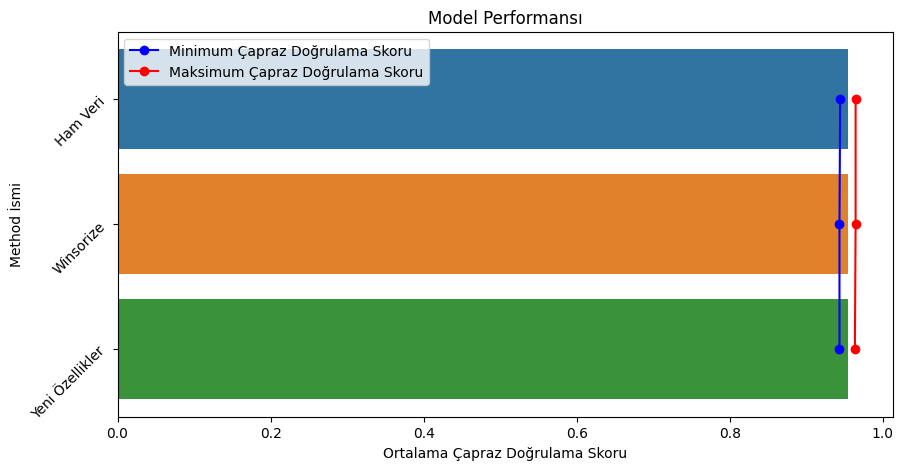

In [73]:
plot_model_performance(rf_performance_with_new_features, "Method İsmi")

### Rastgele Ormanlar Özellik Önemi

In [74]:
rf.fit(featured_X, featured_y)
feature_importances = pd.DataFrame(
    rf.feature_importances_,
    index=featured_X.columns,
    columns=["Önem Skorları"],
).sort_values(by="Önem Skorları", ascending=False)

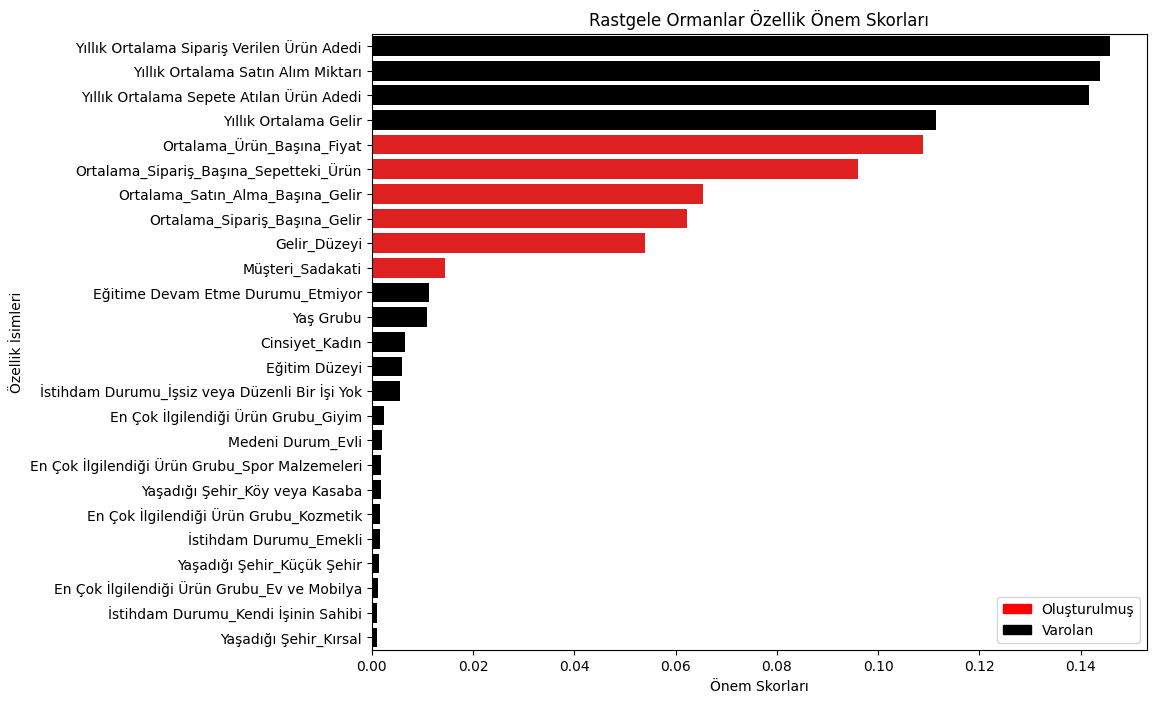

In [75]:
# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x="Önem Skorları",
    y=feature_importances.index,
    data=feature_importances,
    palette=[
        "red"
        if col
        in [
            "Ortalama_Sipariş_Başına_Gelir",
            "Ortalama_Satın_Alma_Başına_Gelir",
            "Ortalama_Sipariş_Başına_Sepetteki_Ürün",
            "Ortalama_Ürün_Başına_Fiyat",
            "Gelir_Düzeyi",
            "Müşteri_Sadakati",
        ]
        else "black"
        for col in feature_importances.index
    ],
)

# Set labels and title
plt.xlabel("Önem Skorları")
plt.ylabel("Özellik İsimleri")
plt.title("Rastgele Ormanlar Özellik Önem Skorları")

# Create custom legend
import matplotlib.patches as mpatches

legend_patches = [
    mpatches.Patch(color="red", label="Oluşturulmuş"),
    mpatches.Patch(color="black", label="Varolan"),
]
plt.legend(handles=legend_patches, loc="lower right")

# Show the plot
plt.show()

### LOFO (Leave One Feature Out)

In [76]:
rf = RandomForestClassifier(random_state=42)

In [77]:
featured_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5460 entries, 0 to 5459
Data columns (total 25 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Yaş Grubu                                       5460 non-null   float64
 1   Eğitim Düzeyi                                   5460 non-null   float64
 2   Yıllık Ortalama Gelir                           5460 non-null   float64
 3   Yıllık Ortalama Satın Alım Miktarı              5460 non-null   float64
 4   Yıllık Ortalama Sipariş Verilen Ürün Adedi      5460 non-null   float64
 5   Yıllık Ortalama Sepete Atılan Ürün Adedi        5460 non-null   float64
 6   Ortalama_Sipariş_Başına_Gelir                   5460 non-null   float64
 7   Ortalama_Satın_Alma_Başına_Gelir                5460 non-null   float64
 8   Ortalama_Sipariş_Başına_Sepetteki_Ürün          5460 non-null   float64
 9   Ortalama_Ürün_Başına_Fiyat                    

In [78]:
lofo_df = pd.concat([featured_X, featured_y], axis=1)
lofo_dataset = Dataset(df=lofo_df, target="Öbek İsmi", features=featured_X.columns)

In [79]:
lofo_imp = LOFOImportance(lofo_dataset, model=rf, scoring="accuracy", cv=5, n_jobs=-1)

In [80]:
# Get feature importance scores
importance_df = lofo_imp.get_importance()

  0%|          | 0/25 [00:00<?, ?it/s]

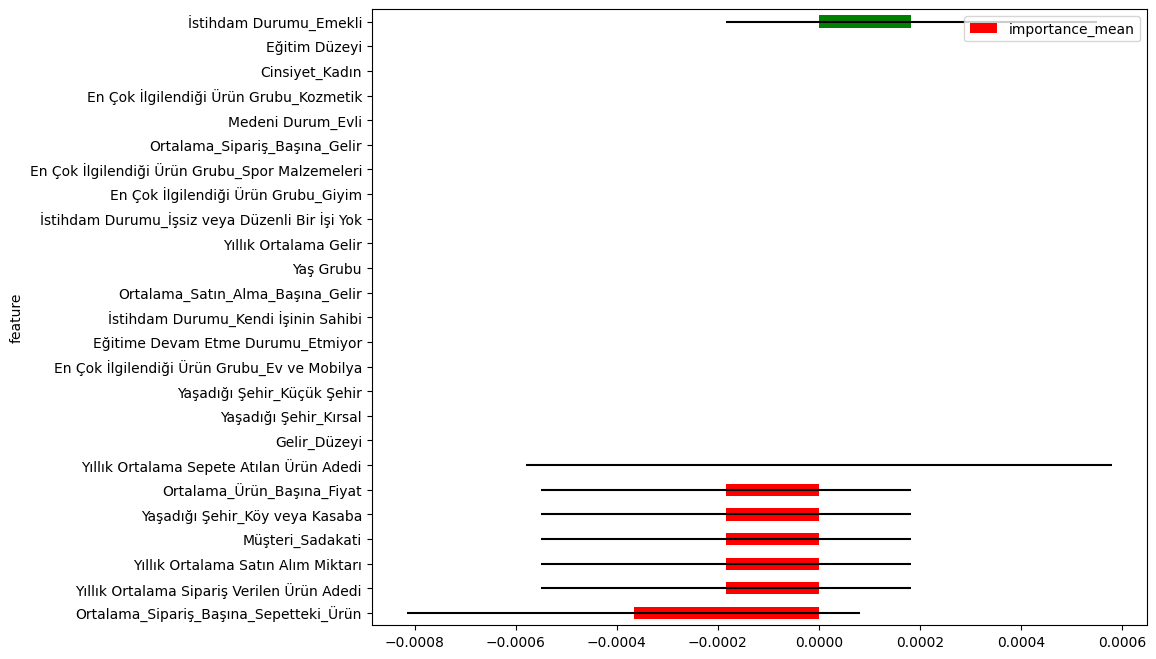

In [81]:
# Plot feature importance
plot_importance(importance_df, figsize=(10, 8))

# Hiperparametre Ayarı

## Oluşturulan Özellikler Üzerinde Temel Model Performansları

In [82]:
model_performance_with_features = pd.DataFrame(
    columns=[
        "Model İsmi",
        "Minimum Çapraz Doğrulama Skoru",
        "Maksimum Çapraz Doğrulama Skoru",
        "Ortalama Çapraz Doğrulama Skoru",
        "Çapraz Doğrulama Standart Sapma",
    ]
)

### Rastgele Ormanlar

In [83]:
rf_cv_scores = cross_val_score(rf, featured_X, featured_y, cv=5, scoring="accuracy")
print(f"Random Forest CV Scores: {rf_cv_scores}")
print(f"Random Forest CV Mean Score: {rf_cv_scores.mean()}")
print(f"Random Forest CV Standard Deviation: {rf_cv_scores.std()}")

Random Forest CV Scores: [0.94322344 0.95512821 0.96336996 0.95512821 0.95421245]
Random Forest CV Mean Score: 0.9542124542124542
Random Forest CV Standard Deviation: 0.006423325244230851


In [84]:
new_row = {
    "Model İsmi": "Rastgele Ormanlar",
    "Minimum Çapraz Doğrulama Skoru": rf_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": rf_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": rf_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": rf_cv_scores.std(),
}
model_performance_with_features.loc[len(model_performance_with_features)] = new_row

### CatBoost

In [85]:
catb_cv_scores = cross_val_score(catb, featured_X, featured_y, cv=5, scoring="accuracy")
print(f"CatBoost CV Scores: {catb_cv_scores}")
print(f"CatBoost CV Mean Score: {catb_cv_scores.mean()}")
print(f"CatBoost CV Standard Deviation: {catb_cv_scores.std()}")

CatBoost CV Scores: [0.94413919 0.95604396 0.96336996 0.95421245 0.95421245]
CatBoost CV Mean Score: 0.9543956043956043
CatBoost CV Standard Deviation: 0.00614031304550925


In [86]:
new_row = {
    "Model İsmi": "CatBoost",
    "Minimum Çapraz Doğrulama Skoru": catb_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": catb_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": catb_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": catb_cv_scores.std(),
}
model_performance_with_features.loc[len(model_performance_with_features)] = new_row

### XGBoost

In [87]:
xgbos_cv_scores = cross_val_score(
    xgbos, featured_X, featured_y, cv=5, scoring="accuracy"
)
print(f"XGBoost CV Scores: {xgbos_cv_scores}")
print(f"XGBoost CV Mean Score: {xgbos_cv_scores.mean()}")
print(f"XGBoost CV Standard Deviation: {xgbos_cv_scores.std()}")

XGBoost CV Scores: [0.94230769 0.9514652  0.96245421 0.95421245 0.9532967 ]
XGBoost CV Mean Score: 0.9527472527472527
XGBoost CV Standard Deviation: 0.006438972831958606


In [88]:
new_row = {
    "Model İsmi": "XGBoost",
    "Minimum Çapraz Doğrulama Skoru": xgbos_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": xgbos_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": xgbos_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": xgbos_cv_scores.std(),
}
model_performance_with_features.loc[len(model_performance_with_features)] = new_row

In [89]:
model_performance_with_features

,Model İsmi,Minimum Çapraz Doğrulama Skoru,Maksimum Çapraz Doğrulama Skoru,Ortalama Çapraz Doğrulama Skoru,Çapraz Doğrulama Standart Sapma
0,Rastgele Ormanlar,0.943223,0.963370,0.954212,0.006423
1,CatBoost,0.944139,0.963370,0.954396,0.006140
2,XGBoost,0.942308,0.962454,0.952747,0.006439


## Optuna ile Hiperparametre Ayarı

### Optuna: Rastgele Ormanlar

In [90]:
def objective(trial, X, y):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "verbose": 0,
        "n_jobs": -1,
    }

    model = RandomForestClassifier(**params)

    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    return np.min([np.mean(scores), np.median([scores])])

In [91]:
rf_study = optuna.create_study(direction="maximize")
# rf_study.optimize(lambda trial: objective(trial, X=featured_X, y=featured_y), n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-09-08 15:31:12,941] A new study created in memory with name: no-name-ee106b34-792e-458a-a2ba-8e21bc50bda6


Uzun çalışma süresi nedeniyle sonuçlar buraya aktarıldı.

In [92]:
# rf_study.best_value #0.9543956043956043
# rf_study.best_params
rf_best_params = {
    "n_estimators": 241,
    "max_depth": 29,
    "min_samples_split": 4,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
}

In [93]:
optuna_rf = RandomForestClassifier(**rf_best_params)
optuna_rf_cv_scores = cross_val_score(
    optuna_rf, featured_X, featured_y, cv=5, scoring="accuracy"
)
print(f"Optuna Random Forest CV Scores: {optuna_rf_cv_scores}")
print(f"Optuna Random Forest CV Mean Score: {optuna_rf_cv_scores.mean()}")
print(f"Optuna Random Forest CV Standard Deviation: {optuna_rf_cv_scores.std()}")

Optuna Random Forest CV Scores: [0.94322344 0.95512821 0.96336996 0.95512821 0.95421245]
Optuna Random Forest CV Mean Score: 0.9542124542124542
Optuna Random Forest CV Standard Deviation: 0.006423325244230851


In [94]:
new_row = {
    "Model İsmi": "Optuna Rastgele Ormanlar",
    "Minimum Çapraz Doğrulama Skoru": optuna_rf_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": optuna_rf_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": optuna_rf_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": optuna_rf_cv_scores.std(),
}

model_performance_with_features.loc[len(model_performance_with_features)] = new_row

### Optuna: CatBoost

In [95]:
def objective(trial, X, y):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-9, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.1, 1.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "auto_class_weights": trial.suggest_categorical(
            "auto_class_weights", ["None", "Balanced"]
        ),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]
        ),
        "thread_count": -1,  # Use all available CPU threads
        "verbose": 0,
        "devices": "0",
        "task_type": "GPU",  # Specify GPU devices (change to your GPU IDs)
    }

    model = cb.CatBoostClassifier(**params)

    # Use cross-validation for optimization
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    return np.mean(scores)

In [96]:
catb_study = optuna.create_study(direction="maximize")
# catb_study.optimize(lambda trial: objective(trial, X=featured_X, y=featured_y), n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-09-08 15:31:27,673] A new study created in memory with name: no-name-1388a6c8-691e-4e92-b9a6-4e2c826280c9


In [97]:
catb_best_params = {
    "iterations": 115,
    "learning_rate": 0.0010949132838511469,
    "depth": 6,
    "l2_leaf_reg": 1.8052556965672773e-09,
    "border_count": 199,
    "random_strength": 0.9332854161168364,
    "bagging_temperature": 5.978321382773984,
    "auto_class_weights": "None",
    "grow_policy": "SymmetricTree",
    "verbose": 0,
}

Uzun çalışma süresi nedeniyle sonuçlar buraya aktarıldı.

In [98]:
optuna_catb = cb.CatBoostClassifier(**catb_best_params)
optuna_catb_cv_scores = cross_val_score(
    optuna_catb, featured_X, featured_y, cv=5, scoring="accuracy"
)
print(f"Optuna CatBoost CV Scores: {optuna_catb_cv_scores}")
print(f"Optuna CatBoost CV Mean Score: {optuna_catb_cv_scores.mean()}")
print(f"Optuna CatBoost CV Standard Deviation: {optuna_catb_cv_scores.std()}")

Optuna CatBoost CV Scores: [0.94322344 0.95421245 0.96336996 0.95421245 0.95421245]
Optuna CatBoost CV Mean Score: 0.9538461538461538
Optuna CatBoost CV Standard Deviation: 0.006386665118740928


In [99]:
new_row = {
    "Model İsmi": "Optuna CatBoost",
    "Minimum Çapraz Doğrulama Skoru": optuna_catb_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": optuna_catb_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": optuna_catb_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": optuna_catb_cv_scores.std(),
}
model_performance_with_features.loc[len(model_performance_with_features)] = new_row

### Optuna: XGBoost

In [100]:
def objective(trial, X, y):
    params = {
        "objective": "multi:softmax",
        "num_class": 8,
        "device": "cuda",
        "eval_metric": "merror",
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        "verbosity": 0,
        "n_jobs": -1,
        "tree_method": "auto",
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0, log=True),
    }

    if params["booster"] in ["gbtree", "dart"]:
        params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        params["n_estimators"] = trial.suggest_int("n_estimators", 1, 1000)
        params["learning_rate"] = trial.suggest_float(
            "learning_rate", 1e-8, 1.0, log=True
        )

    if params["booster"] == "dart":
        params["sample_type"] = trial.suggest_categorical(
            "sample_type", ["uniform", "weighted"]
        )
        params["normalize_type"] = trial.suggest_categorical(
            "normalize_type", ["tree", "forest"]
        )
        params["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        params["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = xgb.XGBClassifier(**params)

    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    return np.min([np.mean(scores), np.median(scores)])

In [101]:
xgb_study = optuna.create_study(direction="maximize")
# xgb_study.optimize(lambda trial: objective(trial, X=featured_X, y=featured_y), n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2023-09-08 15:31:37,198] A new study created in memory with name: no-name-7dda7da7-a0db-43af-9cb0-0f4852ac7ffd


Uzun çalışma süresi nedeniyle sonuçlar buraya aktarıldı.

In [102]:
xgb_best_params = {
    "booster": "gbtree",
    "lambda": 0.0004435326737565798,
    "alpha": 0.46990311368043675,
    "max_depth": 7,
    "eta": 0.0017513577186329986,
    "gamma": 3.7835696767088725e-08,
    "subsample": 0.7864488698190111,
    "colsample_bytree": 0.5797555192231851,
    "n_estimators": 861,
    "learning_rate": 0.2235058502708365,
    "n_jobs": -1,
    "verbosity": 0,
    "objective": "multi:softmax",
    "num_class": 8,
    "eval_metric": "merror",
}

In [103]:
optuna_xgb = xgb.XGBClassifier(**xgb_best_params)
optuna_xgb_cv_scores = cross_val_score(
    optuna_xgb, featured_X, featured_y, cv=5, scoring="accuracy"
)
print(f"Optuna XGBoost CV Scores: {optuna_xgb_cv_scores}")
print(f"Optuna XGBoost CV Mean Score: {optuna_xgb_cv_scores.mean()}")
print(f"Optuna XGBoost CV Standard Deviation: {optuna_xgb_cv_scores.std()}")

Optuna XGBoost CV Scores: [0.94230769 0.95512821 0.96336996 0.95421245 0.95421245]
Optuna XGBoost CV Mean Score: 0.9538461538461538
Optuna XGBoost CV Standard Deviation: 0.006719390596279919


In [104]:
new_row = {
    "Model İsmi": "Optuna XGBoost",
    "Minimum Çapraz Doğrulama Skoru": optuna_xgb_cv_scores.min(),
    "Maksimum Çapraz Doğrulama Skoru": optuna_xgb_cv_scores.max(),
    "Ortalama Çapraz Doğrulama Skoru": optuna_xgb_cv_scores.mean(),
    "Çapraz Doğrulama Standart Sapma": optuna_xgb_cv_scores.std(),
}
model_performance_with_features.loc[len(model_performance_with_features)] = new_row

## Sonuçlar

In [105]:
model_performance_with_features

,Model İsmi,Minimum Çapraz Doğrulama Skoru,Maksimum Çapraz Doğrulama Skoru,Ortalama Çapraz Doğrulama Skoru,Çapraz Doğrulama Standart Sapma
0,Rastgele Ormanlar,0.943223,0.963370,0.954212,0.006423
1,CatBoost,0.944139,0.963370,0.954396,0.006140
2,XGBoost,0.942308,0.962454,0.952747,0.006439
3,Optuna Rastgele Ormanlar,0.943223,0.963370,0.954212,0.006423
4,Optuna CatBoost,0.943223,0.963370,0.953846,0.006387
5,Optuna XGBoost,0.942308,0.963370,0.953846,0.006719


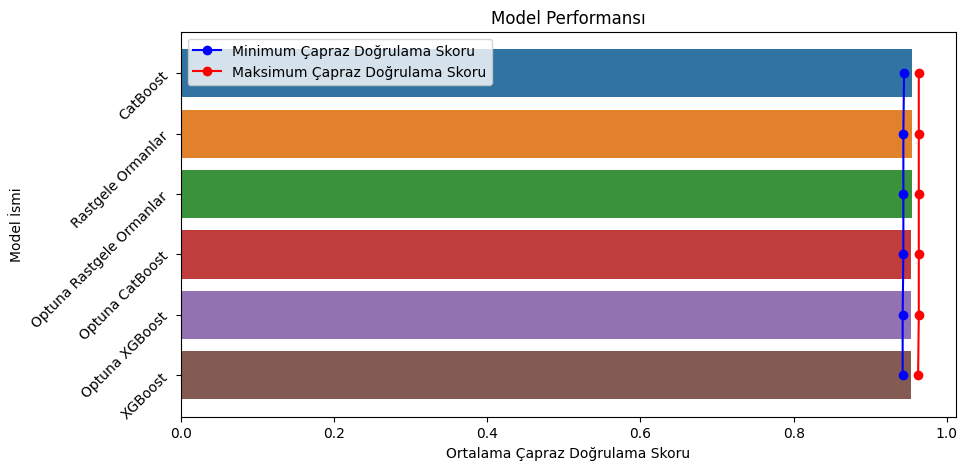

In [106]:
plot_model_performance(model_performance_with_features, "Model İsmi")

# Submission Veri Setinin Oluşturulması

In [107]:
test_df = pd.read_csv(TEST_DATASET_PATH, index_col="index")
test_df.head()

,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Yıllık Ortalama Sepete Atılan Ürün Adedi
index,,,,,,,,,,,,
0,Erkek,51-60,Evli,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,365331.930346,Köy veya Kasaba,Giyim,5566.587664,15.442635,Etmiyor,19.646460
1,Erkek,41-50,Bekar,Lise Mezunu,İşsiz veya Düzenli Bir İşi Yok,414899.236174,Büyük Şehir,Spor Malzemeleri,6756.766203,14.957246,Etmiyor,19.675863
2,Kadın,>60,Evli,Eğitimsiz,İşsiz veya Düzenli Bir İşi Yok,152825.872271,Küçük Şehir,Giyim,4493.915682,10.907930,Etmiyor,46.904518
3,Kadın,51-60,Evli,Doktora Ötesi,Düzenli ve Ücretli Bir İşi Var,489052.908472,Köy veya Kasaba,Kozmetik,42670.646595,32.333021,Etmiyor,48.083609
4,Erkek,18-30,Evli,Yüksek Lisans Mezunu,Kendi İşinin Sahibi,323635.711534,Küçük Şehir,Giyim,5959.266948,4.519968,Etmiyor,12.752491


In [108]:
continuos_cols = [
    "Yıllık Ortalama Gelir",
    "Yıllık Ortalama Satın Alım Miktarı",
    "Yıllık Ortalama Sipariş Verilen Ürün Adedi",
    "Yıllık Ortalama Sepete Atılan Ürün Adedi",
]

test_X = test_df.copy()
# Loop through columns and apply winsorize
for col in continuos_cols:
    test_X[col] = winsorize(test_df[col], limits=[0.05, 0.05])

In [109]:
# Yıllık Ortalama Sipariş Verilen Ürün Adedi ile Yıllık Ortalama Gelir arasındaki ortalama sipariş miktarı hesaplanıyor
test_X["Ortalama_Sipariş_Başına_Gelir"] = (
    test_df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]
    / test_df["Yıllık Ortalama Gelir"]
)

# Yıllık Ortalama Satın Alım Miktarı ile Yıllık Ortalama Gelir arasındaki ortalama satın alma miktarı hesaplanıyor
test_X["Ortalama_Satın_Alma_Başına_Gelir"] = (
    test_df["Yıllık Ortalama Satın Alım Miktarı"] / test_df["Yıllık Ortalama Gelir"]
)

# Yıllık Ortalama Sipariş Verilen Ürün Adedi ile Yıllık Ortalama Sepete Atılan Ürün Adedi arasındaki ortalama ürün adeti hesaplanıyor
test_X["Ortalama_Sipariş_Başına_Sepetteki_Ürün"] = (
    test_df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]
    / test_df["Yıllık Ortalama Sepete Atılan Ürün Adedi"]
)

# Yıllık Ortalama Satın Alım Miktarı ile Yıllık Ortalama Sipariş Verilen Ürün Adedi arasındaki ortalama ürün fiyatı hesaplanıyor
test_X["Ortalama_Ürün_Başına_Fiyat"] = (
    test_df["Yıllık Ortalama Satın Alım Miktarı"]
    / test_df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"]
)

# Sonsuz veya negatif değerler 0 ile değiştiriliyor
test_X.replace([np.inf, -np.inf], 0, inplace=True)

In [110]:
# "Yıllık Ortalama Gelir" verisi için çeyreklikler ve IQR değeri hesaplanıyor
q1 = np.percentile(test_X["Yıllık Ortalama Gelir"], 25)
median = np.median(test_X["Yıllık Ortalama Gelir"])
q3 = np.percentile(test_X["Yıllık Ortalama Gelir"], 75)
iqr = q3 - q1

# Alt ve üst sınırlar hesaplanıyor
minimum = q1 - 1.5 * iqr
maximum = q3 + 1.5 * iqr

# Gelir seviyeleri için aralık sınırları belirleniyor ve etiketler atanıyor
bin_edges = [0, minimum, q1, median, q3, maximum, float("inf")]
bin_edges.sort()
bin_labels = [
    "çok düşük",
    "düşük gelir",
    "ortalama-düşük gelir",
    "ortalama-yüksek gelir",
    "yüksek gelir",
    "çok yüksek",
]

In [111]:
test_X["Gelir_Düzeyi"] = pd.cut(
    test_X["Yıllık Ortalama Gelir"], bins=bin_edges, labels=bin_labels
).astype(object)

In [112]:
# "Yıllık Ortalama Sipariş Verilen Ürün Adedi" değerlerinin ortancası hesaplanıyor
median_order_count = test_X["Yıllık Ortalama Sipariş Verilen Ürün Adedi"].median()

# Müşteri bağlılığı belirlemek için her bir müşteri için bir etiket atanıyor
# Eğer sipariş verilen ürün adedi ortancadan büyükse etiket 1, değilse etiket 0 atanıyor
test_X["Müşteri_Sadakati"] = (
    test_X["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] > median_order_count
).astype(object)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [113]:
test_X = encode_X(
    test_X,
    ordinal_encoding=["Yaş Grubu", "Eğitim Düzeyi", "Gelir_Düzeyi", "Müşteri_Sadakati"],
)

In [114]:
rf = RandomForestClassifier(random_state=42)
rf.fit(featured_X, featured_y)

RandomForestClassifier(random_state=42)

In [115]:
rf_predictions = rf.predict(test_X)

In [116]:
rf_predictions_df = pd.DataFrame(rf_predictions, columns=["Öbek İsmi"])
rf_predictions_df

,Öbek İsmi
0,2
1,2
2,1
3,5
4,0
...,...
2335,7
2336,1
2337,6
2338,4


In [117]:
rf_predictions_df = decode_y(rf_predictions_df)
# save_submission(rf_predictions_df, working_directory)

In [118]:
catb = cb.CatBoostClassifier(
    classes_count=8, loss_function="MultiClass", random_state=42, verbose=False
)
catb.fit(featured_X, featured_y)

In [119]:
catb_predictions = catb.predict(test_X)

In [120]:
catb_predictions_df = pd.DataFrame(catb_predictions, columns=["Öbek İsmi"])
catb_predictions_df

,Öbek İsmi
0,2
1,2
2,1
3,5
4,0
...,...
2335,7
2336,1
2337,6
2338,4


In [121]:
catb_predictions_df = decode_y(catb_predictions_df)
# save_submission(catb_predictions_df, working_directory)